# SED fitting using eazy-py on the SPHEREx yarn cluster

## install eazy-py from https://github.com/gbrammer/eazy-py
- For templates and filters, https://github.com/gbrammer/eazy-photoz/

## what you need: 
- `premade-tempfilt.pickle` : sed-fit-grid which has all of filters and templates information

## what `ez` is: 
> `inputcatalog in csv` + `premade-tempfilt` + `param` <br> -> `ez` instance which will be broadcasted to all nodes

## The key point is to broadcast `ez` to all worker nodes

## Basic Packages

In [1]:
#!pip list |grep pyarrow

In [2]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import numpy as np
from astropy.table import Table
from matplotlib.ticker import MultipleLocator
import pandas as pd

from astropy.utils.exceptions import AstropyWarning
import warnings

pd.set_option('display.max_rows', 300)
    
np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

# https://github.com/gbrammer/eazy-py
import eazy

In [3]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py
#from netCDF4 import Dataset
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pq

from functools import reduce
import operator
import gc

In [4]:
# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [5]:
!pip list |grep eazy

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
eazy                      0.6.8               


In [6]:
!pwd

/home/shong/work/sed-fit/pyspark-eazypy/notebook


In [7]:
!ls -alF ../

total 20
drwxrwxr-x 5 shong shong 4096  2월 22 14:54 ./
drwxrwxr-x 4 shong shong 4096  2월 22 15:38 ../
drwxrwxr-x 2 shong shong 4096  2월 13 13:36 data/
drwxrwxr-x 3 shong shong 4096  3월 18 18:04 notebook/
drwxrwxr-x 4 shong shong 4096  2월 26 15:49 premade-data/


In [8]:
!ls -alF

total 115840
drwxrwxr-x 3 shong shong     4096  3월 18 18:04 ./
drwxrwxr-x 5 shong shong     4096  2월 22 14:54 ../
drwxrwxr-x 2 shong shong     4096  3월  6 11:05 .ipynb_checkpoints/
lrwxrwxrwx 1 shong shong       78  3월  8 18:36 FILTER.RES.latest -> /home/shong/work/sed-fit/pyspark-eazypy/premade-data/filters/FILTER.RES.latest
-rw-rw-r-- 1 shong shong  3627073  3월  8 18:36 SPHERExRefCat_eazypy_test10000.cat
-rw-rw-r-- 1 shong shong 45141598  3월 18 18:02 SPHERExRefCat_eazypy_test_all.cat
-rw-rw-r-- 1 shong shong  3611725  3월  8 18:36 filled_SPHERExRefCat_eazypy_test10000.cat
-rw-rw-r-- 1 shong shong 44953445  3월 18 18:02 filled_SPHERExRefCat_eazypy_test_all.cat
-rw-rw-r-- 1 shong shong 18584125  2월 28 13:52 premade_tempfilt.pickle
-rw-rw-r-- 1 shong shong   699018  3월  8 18:37 run_eazypy-for-pyspark-yarn-v0-local-test-pilot-making-premade_tempfilt.ipynb
-rw-rw-r-- 1 shong shong   912474  3월  5 17:22 run_eazypy-for-pyspark-yarn-v1-local-test-full-cat-using-premade_tempfilt.ipynb
-rw-rw-r-

In [9]:
!ls -alFh ../data/

total 74M
drwxrwxr-x 2 shong shong 4.0K  2월 13 13:36 ./
drwxrwxr-x 5 shong shong 4.0K  2월 22 14:54 ../
-rw-rw-r-- 1 shong shong  74M  2월 13 10:59 Gaia_EDR3.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000000.fits
-rw-rw-r-- 1 shong shong 8.5K  2월 14 09:26 SPHEREx_RefCat.BandsInfo.fits


## Read `fits` table and convert this to pandas and spark dataframes

In [10]:
#dir(eazy)

In [11]:
#dir(eazy.photoz)

In [12]:
#dir(eazy.photoz.PhotoZ)

In [13]:
#dir(eazy.photoz.TemplateGrid)

### Input RefCat File Path + Name: fits format

In [14]:
catdir = '/home/shong/work/sed-fit/pyspark-eazypy/data/'

In [15]:
#%ls -lh $catdir

In [16]:
incatfilename = 'Gaia_EDR3.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000000.fits'

#### fits table read

In [17]:
#phot = Table.read(catdir+'Gaia_EDR3.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000000.fits')
phot = Table.read(catdir+incatfilename)

#### to_pandas()

In [18]:
photdf = phot.to_pandas()

> Wierdly enough, `int64` is not Null-able. Hence, `pandas` puts  `Gaia_DR2_source_id VVV_DR4_sourceid PS1DR1_Stack_objID` in the `float64` format, which is Null-able. After this ad-hoc conversion, we need to reformat the columns using `Int64`, a Null-able integer in `pandas`. 

> `np.NaN` turns out a `float`. `null` also turns out another value; hence, `null` and `nan` are not exactly the same. In Spark Dataframe, `null` is a default value, instead of `nan`. There will be subtle differences between `null` and `nan`, and, `pandasDF` and `sparkDF`. 

#### SPHEREx Reference Catalog Contents 

In [19]:
numcat = len(photdf.index)
print(numcat)

124117


In [20]:
photdf.head(4).T

,0,1,2,3
SPHERExRefID,1657553357130170369,1657553357130170370,1657553357398605824,1657553361425137666
Gaia_EDR3_source_id,-9999,-9999,-9999,-9999
PS1_DR1_StackObject_objID,-9999,-9999,-9999,-9999
CatWISE_source_id,b'0453p030_b0-060944',b'0453p030_b0-064313',b'0453p030_b0-032120',b'0453p030_b0-056109'
AllWISE_designation,b'N/A',b'N/A',b'J025958.65+022234.9',b'N/A'
2MASS_designation,b'N/A',b'N/A',b'N/A',b'N/A'
ra,44.992913,44.991372,44.994414,45.004331
dec,2.377934,2.38027,2.376334,2.380586
ra_error,0.000091,0.000109,0.000056,0.000095
dec_error,0.000089,0.000112,0.000054,0.000095


In [21]:
photdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124117 entries, 0 to 124116
Data columns (total 80 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SPHERExRefID               124117 non-null  int64  
 1   Gaia_EDR3_source_id        124117 non-null  int64  
 2   PS1_DR1_StackObject_objID  124117 non-null  int64  
 3   CatWISE_source_id          124117 non-null  object 
 4   AllWISE_designation        124117 non-null  object 
 5   2MASS_designation          124117 non-null  object 
 6   ra                         124117 non-null  float64
 7   dec                        124117 non-null  float64
 8   ra_error                   124117 non-null  float64
 9   dec_error                  124117 non-null  float64
 10  coord_src                  124117 non-null  int64  
 11  pmra                       124117 non-null  float64
 12  pmra_error                 124117 non-null  float64
 13  pmdec                      12

In [22]:
# change all int-ish to Int64 for `null integer` : I guess now this issue is resolved; so, commentted out
#photdf['SPHERExRefID'] = photdf['SPHERExRefID'].astype(pd.Int64Dtype())
#photdf['Gaia_EDR3_source_id'] = photdf['Gaia_EDR3_source_id'].astype(pd.Int64Dtype())
#photdf['PS1_DR1_StackObject_objID'] = photdf['PS1_DR1_StackObject_objID'].astype(pd.Int64Dtype())

In [23]:
#photdf.info()

### Now, let's take all objects for SED fits

In [24]:
# Replace all NaNs to -99.0
#phot.filled_value = np.float64(np.nan)
#phot.filled(-99.0) # doesn't work! 

# select top 100 objects for testing
sel_phot = phot

In [25]:
# Make EAZY inputfile
inputfile = 'SPHERExRefCat_eazypy_test_all.cat'

# spec z's are unknown, set to an arbitrary negative number as unknown
z_spec = -1.0

bands_ref = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 
             'WISE_W1','WISE_W2','WISE_W3','WISE_W4',
             '2MASS_J','2MASS_H','2MASS_Ks',
             'PS1_g', 'PS1_r','PS1_i','PS1_z','PS1_y']

#bands_ref = ['WISE_W1','WISE_W2','WISE_W3','WISE_W4',
#             '2MASS_J','2MASS_H','2MASS_Ks',
#             'PS1_g', 'PS1_r','PS1_i','PS1_z','PS1_y']

bands_err = [b + '_error' for b in bands_ref]

bands_eazy = ['gaia_G', 'gaia_BP', 'gaia_RP',
              'w1', 'w2', 'w3', 'w4',
              '2massJ', '2massH', '2massKs',
              'ps1_g', 'ps1_r', 'ps1_i', 'ps1_z', 'ps1_y']

header_list = [' f_'+ b + ' e_' + b for b in bands_eazy]
header_string =  '#id' + ''.join(header_list) + ' z_spec'

print(header_string)

with open(inputfile,'w') as infile:
    print(header_string, file=infile)
    for r in sel_phot:
        ind = r['SPHERExRefID']
        flux_list = [f" {r[b]} {r[e]}" for b, e in zip(bands_ref, bands_err)]
        flux_string = f'{ind}' + ''.join(flux_list) + f' {z_spec}'
        print(flux_string, file=infile)

#id f_gaia_G e_gaia_G f_gaia_BP e_gaia_BP f_gaia_RP e_gaia_RP f_w1 e_w1 f_w2 e_w2 f_w3 e_w3 f_w4 e_w4 f_2massJ e_2massJ f_2massH e_2massH f_2massKs e_2massKs f_ps1_g e_ps1_g f_ps1_r e_ps1_r f_ps1_i e_ps1_i f_ps1_z e_ps1_z f_ps1_y e_ps1_y z_spec


In [26]:
# Replace all NaNs to -99.0 
df = pd.read_csv(inputfile, delimiter=' ')
df.replace(np.nan, -99.0, inplace=True)
df.to_csv('filled_'+inputfile, sep=' ', index=False)

In [27]:
import gc
gc.collect()

0

In [28]:
%pwd

'/home/shong/work/sed-fit/pyspark-eazypy/notebook'

In [29]:
%ls -alF ./

total 115836
drwxrwxr-x 3 shong shong     4096  3월 18 18:04 ./
drwxrwxr-x 5 shong shong     4096  2월 22 14:54 ../
drwxrwxr-x 2 shong shong     4096  3월  6 11:05 .ipynb_checkpoints/
lrwxrwxrwx 1 shong shong       78  3월  8 18:36 FILTER.RES.latest -> /home/shong/work/sed-fit/pyspark-eazypy/premade-data/filters/FILTER.RES.latest
-rw-rw-r-- 1 shong shong  3627073  3월  8 18:36 SPHERExRefCat_eazypy_test10000.cat
-rw-rw-r-- 1 shong shong 45141598  3월 18 18:04 SPHERExRefCat_eazypy_test_all.cat
-rw-rw-r-- 1 shong shong  3611725  3월  8 18:36 filled_SPHERExRefCat_eazypy_test10000.cat
-rw-rw-r-- 1 shong shong 44953445  3월 18 18:04 filled_SPHERExRefCat_eazypy_test_all.cat
-rw-rw-r-- 1 shong shong 18584125  2월 28 13:52 premade_tempfilt.pickle
-rw-rw-r-- 1 shong shong   699018  3월  8 18:37 run_eazypy-for-pyspark-yarn-v0-local-test-pilot-making-premade_tempfilt.ipynb
-rw-rw-r-- 1 shong shong   912474  3월  5 17:22 run_eazypy-for-pyspark-yarn-v1-local-test-full-cat-using-premade_tempfilt.ipynb
-rw-rw-r-

### Load the pre-made template file

> Key input files: <br> [1] `premade_tempfilt.pickle`: this has all template+grid info for fits 
<br> [2] `zphot.param.default.HONG.eazypy` : default settings. Newly added `params` settings will be overrided on this defaults. <br> [3] `zphot.HONG.translate` : default filter id and real filter transmission curves

In [30]:
import pickle

In [31]:
# Skip these lines if you first run ez for building `premade_tempfilt`
with open('premade_tempfilt.pickle', 'rb') as rfile:
    premade_tempfilt = pickle.load(rfile)

In [32]:
%%time

outputfile = 'SPHERExRefCat_eazypy_test_all_photoz'
params = {}
# use fsps templates in zphot.param.default.eazypy
params['CATALOG_FILE'] = 'filled_'+inputfile
params['MAIN_OUTPUT_FILE'] = outputfile
params['FIX_ZSPEC'] = 'n'
params['TEMPLATES_FILE'] = '../premade-data/brown_templates.param' 
params['TEMPLATE_COMBOS'] = 1  # one template at a time
params['N_MIN_COLORS'] = 3  # EAZY default value : 5
params['APPLY_PRIOR'] = 'y'
params['PRIOR_FILE'] = 'templates/prior_K_TAO.dat'
params['PRIOR_FILTER'] = 163 # 2MASS Ks band
params['GET_ZP_OFFSETS'] = 'n' # do not apply zeropoint offset
params['PRIOR_ABZP'] = 25
params['MW_EBV'] = 0.0 # apply galactic extinction
params['VERBOSITY'] = 1.0 # set 2.0 or larger to print all verbose information 

params['Z_MAX'] = 6.0
params['Z_STEP'] = 0.01

    
params['VERBOSITY'] = 1
    
#ez = eazy.photoz.PhotoZ(param_file='zphot.param.default.HONG.eazypy',translate_file='zphot.HONG.translate',
#                        zeropoint_file=None, params=params,
#                        load_prior=True, load_products=False)

ez = eazy.photoz.PhotoZ(param_file='zphot.param.default.HONG.eazypy',translate_file='zphot.HONG.translate', \
                        zeropoint_file=None, params=params, \
                        load_prior=True, load_products=False, tempfilt=premade_tempfilt)

Read default param file: zphot.param.default.HONG.eazypy
Parameter default: CATALOG_FORMAT = ascii.commented_header
Read CATALOG_FILE: filled_SPHERExRefCat_eazypy_test_all.cat
   >>> NOBJ = 124117
f_gaia_G e_gaia_G (406): Gaia_G
f_gaia_BP e_gaia_BP (407): Gaia_BP
f_gaia_RP e_gaia_RP (408): Gaia_RP
f_w1 e_w1 (244): WISE/RSR-W1.txt
f_w2 e_w2 (245): WISE/RSR-W2.txt
f_w3 e_w3 (246): WISE/RSR-W3.txt
f_w4 e_w4 (247): WISE/RSR-W4.txt
f_2massJ e_2massJ (161): 2MASS/J.res
f_2massH e_2massH (162): 2MASS/H.res
f_2massKs e_2massKs (163): 2MASS/K.res
f_ps1_g e_ps1_g (334): PAN-STARRS/PS1.g
f_ps1_r e_ps1_r (335): PAN-STARRS/PS1.r
f_ps1_i e_ps1_i (336): PAN-STARRS/PS1.i
f_ps1_z e_ps1_z (337): PAN-STARRS/PS1.z
f_ps1_y e_ps1_y (338): PAN-STARRS/PS1.y
Set sys_err = 0.01 (positive=True)
Read PRIOR_FILE:  templates/prior_K_TAO.dat


194it [00:02, 66.33it/s]

CPU times: user 3.9 s, sys: 149 ms, total: 4.05 s
Wall time: 4.04 s


In [33]:
## Save the TemplateGrid as a pickle for later usages 
#premade_tempfilt = ez.tempfilt
#with open('premade_tempfilt.pickle', 'wb') as wfile:
#    pickle.dump(premade_tempfilt, wfile, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera, https://stackoverflow.com/a/109493/1870 modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

# Get the size of the ez variable in bytes
size_of_ez = sys.getsizeof(ez)

# Optionally, convert the size to a human-readable format
human_readable_size = sizeof_fmt(size_of_ez)

print(f"The memory size of the 'ez' variable is approximately: {size_of_ez} bytes ({human_readable_size})")


The memory size of the 'ez' variable is approximately: 48 bytes (48.0 B)


> This shows that `ez` itself does not have catalog information. The input catalog, saved as a csv, has all of necessary cat info for fitting

In [35]:
#dir(ez)
ez.NOBJ

124117

## Initialize SparkSession and Broadcast `ez`

#### this dynamic allocation option may not work properly

```
%%time
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W


spark = SparkSession.builder \
    .master("yarn") \
    .appName("spark-shell") \
    .config("spark.driver.maxResultSize", "32g") \
    .config("spark.driver.memory", "32g") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.executor.memory", "10g") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.instances", "50") \
    .config("spark.shuffle.service.enabled", "true") \
    .getOrCreate()


sc = spark.sparkContext
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
```

#### use this opion as usual

In [36]:
%%time
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W


spark = SparkSession.builder \
    .master("yarn") \
    .appName("spark-shell") \
    .config("spark.driver.maxResultSize", "32g") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "7g") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "100") \
    .getOrCreate()


sc = spark.sparkContext
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

CPU times: user 14.4 ms, sys: 9.36 ms, total: 23.8 ms
Wall time: 29.6 s


In [37]:
sc.getConf().getAll()[:10]

[('spark.driver.memory', '32g'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'spark05'),
 ('spark.driver.appUIAddress', 'http://spark00:4040'),
 ('spark.app.id', 'application_1710297656765_0005'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_URI_BASES',
  'http://spark05:8088/proxy/application_1710297656765_0005'),
 ('spark.driver.maxResultSize', '32g'),
 ('spark.app.startTime', '1710752690000'),
 ('spark.master', 'yarn'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir',
  'file:/home/shong/work/sed-fit/pyspark-eazypy/notebook/spark-warehouse')]

#### Broadcasting variable

In [38]:
%%time
bcastez = sc.broadcast(ez)

CPU times: user 0 ns, sys: 6.8 s, total: 6.8 s
Wall time: 13.4 s


In [39]:
# Get the size of the ez variable in bytes
size_of_bcastez = sys.getsizeof(bcastez)

# Optionally, convert the size to a human-readable format
human_readable_size = sizeof_fmt(size_of_bcastez)

print(f"The memory size of the 'bcastez' variable is approximately: {size_of_bcastez} bytes ({human_readable_size})")


The memory size of the 'bcastez' variable is approximately: 48 bytes (48.0 B)


### Explore what the `bcastez` class has

In [40]:
%%time
ez.zgrid

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs


array([0.01      , 0.02015067, 0.03040335, 0.04075908, 0.05121888,
       0.06178381, 0.07245491, 0.08323326, 0.09411994, 0.10511602,
       0.11622263, 0.12744085, 0.13877182, 0.15021667, 0.16177654,
       0.17345259, 0.18524598, 0.1971579 , 0.20918953, 0.22134209,
       0.23361678, 0.24601483, 0.2585375 , 0.27118602, 0.28396165,
       0.29686567, 0.3098994 , 0.3230641 , 0.3363611 , 0.34979177,
       0.3633574 , 0.37705937, 0.39089903, 0.4048778 , 0.41899708,
       0.43325824, 0.4476627 , 0.46221197, 0.47690743, 0.4917506 ,
       0.50674295, 0.521886  , 0.5371812 , 0.5526301 , 0.56823426,
       0.5839953 , 0.5999147 , 0.61599416, 0.63223517, 0.6486394 ,
       0.66520846, 0.68194413, 0.69884795, 0.71592164, 0.73316693,
       0.75058556, 0.76817924, 0.7859497 , 0.8038988 , 0.8220283 ,
       0.84033996, 0.8588357 , 0.87751734, 0.8963867 , 0.9154457 ,
       0.93469626, 0.95414025, 0.9737797 , 0.9936165 , 1.0136527 ,
       1.0338902 , 1.0543312 , 1.0749775 , 1.0958314 , 1.11689

In [41]:
%%time
bcastez.value.zgrid

CPU times: user 22.7 ms, sys: 4.75 s, total: 4.78 s
Wall time: 4.78 s


array([0.01      , 0.02015067, 0.03040335, 0.04075908, 0.05121888,
       0.06178381, 0.07245491, 0.08323326, 0.09411994, 0.10511602,
       0.11622263, 0.12744085, 0.13877182, 0.15021667, 0.16177654,
       0.17345259, 0.18524598, 0.1971579 , 0.20918953, 0.22134209,
       0.23361678, 0.24601483, 0.2585375 , 0.27118602, 0.28396165,
       0.29686567, 0.3098994 , 0.3230641 , 0.3363611 , 0.34979177,
       0.3633574 , 0.37705937, 0.39089903, 0.4048778 , 0.41899708,
       0.43325824, 0.4476627 , 0.46221197, 0.47690743, 0.4917506 ,
       0.50674295, 0.521886  , 0.5371812 , 0.5526301 , 0.56823426,
       0.5839953 , 0.5999147 , 0.61599416, 0.63223517, 0.6486394 ,
       0.66520846, 0.68194413, 0.69884795, 0.71592164, 0.73316693,
       0.75058556, 0.76817924, 0.7859497 , 0.8038988 , 0.8220283 ,
       0.84033996, 0.8588357 , 0.87751734, 0.8963867 , 0.9154457 ,
       0.93469626, 0.95414025, 0.9737797 , 0.9936165 , 1.0136527 ,
       1.0338902 , 1.0543312 , 1.0749775 , 1.0958314 , 1.11689

In [42]:
dir(bcastez.value)

['ARRAY_DTYPE',
 'DEC',
 'MW_EBV',
 'NDRAWS',
 'NFILT',
 'NOBJ',
 'NTEMP',
 'NZ',
 'OBJID',
 'PIT',
 'RA',
 'RES',
 'TEF',
 'TEFgrid',
 'ZML_WITH_BETA_PRIOR',
 'ZML_WITH_PRIOR',
 'ZPHOT_AT_ZSPEC',
 'ZPHOT_USER',
 'ZSPEC',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_uncertainties',
 '_csv_from_arrays',
 '_fit_at_redshift',
 '_fit_on_zgrid',
 '_get_prior_mag',
 '_loss',
 '_make_template_error_function',
 '_redshift_pairs',
 'abs_mag',
 'apply_spatial_offset',
 'cat',
 'cdf_percentiles',
 'chi2_best',
 'chi2_fit',
 'clip_wavelength',
 'coeffs_best',
 'coeffs_draws',
 'compute_best_risk',
 'compute_full_risk',
 'compute_lnp',
 'compute_tef_lnp

In [43]:
dir(bcastez.value.templates)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [44]:
# Get the size of the ez variable in bytes
size_of_ez = sys.getsizeof(bcastez.value.templates)

# Optionally, convert the size to a human-readable format
human_readable_size = sizeof_fmt(size_of_ez)

print(f"The memory size of the 'ez.fnu' variable is approximately: {size_of_ez} bytes ({human_readable_size})")

The memory size of the 'ez.fnu' variable is approximately: 1264 bytes (1.2 KiB)


In [45]:
#dir(ez)
bcastez.value.NOBJ

124117

# Modding `eazy-py` for PySpark


> I modify some codes to make them run on Spark Cluster

In [46]:
# Some Global Variables from the PhotoZ class
TRUE_VALUES = [True, 'y', 'yes', 'Y', 'Yes']

__all__ = ["PhotoZ", "TemplateGrid"]

DEFAULT_UBVJ_FILTERS = [153,154,155,161] # Maiz-Appellaniz & 2MASS

DEFAULT_RF_FILTERS = [270, 274] # UV tophat
DEFAULT_RF_FILTERS += [120, 121] # GALEX
DEFAULT_RF_FILTERS += [156, 157, 158, 159, 160] #SDSS
DEFAULT_RF_FILTERS += [161, 162, 163] # 2MASS

MIN_VALID_FILTERS = 1

NUVRK_FILTERS = [121, 158, 163]

CDF_SIGMAS = np.linspace(-5, 5, 51)

## KASI Modded Functions

In [47]:
# A new ad-hoc fit_object function

def kasi_fit_object(ez, iobj=0, z=0):
    """
    Fit on the redshift grid
    """
    from scipy.optimize import nnls
    #import np.linalg
                
    fnu_i = ez.fnu[iobj, :]*ez.ext_redden
    efnu_i = ez.efnu[iobj,:]*ez.ext_redden
    ok_band = (fnu_i > ez.param['NOT_OBS_THRESHOLD']) & (efnu_i > 0)
        
    A = ez.tempfilt(z)
    var = (0.0*fnu_i)**2 + efnu_i**2 + (ez.TEF(z)*fnu_i)**2
        
    chi2 = np.zeros(ez.NZ, dtype=ez.ARRAY_DTYPE)
    coeffs = np.zeros((ez.NZ, ez.NTEMP), dtype=ez.ARRAY_DTYPE)
        
    for iz in range(ez.NZ):
        A = ez.tempfilt(ez.zgrid[iz])
        var = (0.0*fnu_i)**2 + efnu_i**2 + (ez.TEF(ez.zgrid[iz])*fnu_i)**2
        rms = np.sqrt(var)
            
        ok_temp = (np.sum(A, axis=1) > 0)
        if ok_temp.sum() == 0:
            chi2[iz] = np.inf
            coeffs[iz, :] = 0.
            continue
                
        try:
            coeffs_x, rnorm = nnls((A/rms).T[ok_band,:][:,ok_temp], (fnu_i/rms)[ok_band])
            coeffs_i = np.zeros(A.shape[0], dtype=ez.ARRAY_DTYPE)
            coeffs_i[ok_temp] = coeffs_x
        except:
            coeffs_i = np.zeros(A.shape[0], dtype=ez.ARRAY_DTYPE)
                
        fmodel = np.dot(coeffs_i, A)
        chi2[iz] = np.sum((fnu_i-fmodel)**2/var*ok_band)
        coeffs[iz, :] = coeffs_i
    
    
    
        
    return iobj, chi2, coeffs, fmodel



In [48]:
def kasi_compute_lnp(ez, prior=False, beta_prior=False, clip_wavelength=1100, in_place=True):

    import time
        
    has_chi2 = (ez.chi2_fit != 0).sum(axis=1) > 0 
    #min_chi2 = ez.chi2_fit[has_chi2,:].min(axis=1)
        
    loglike = -ez.chi2_fit[has_chi2,:]/2.
    #pz = np.exp(-(ez.chi2_fit[has_chi2,:].T-min_chi2)/2.).T
        
    if ez.param['VERBOSITY'] >= 2:
        print('compute_lnp ({0})'.format(time.ctime()))
            
    if hasattr(ez, 'tef_lnp'):
        if ez.param['VERBOSITY'] >= 2:
            print(' ... tef_lnp')
            
        loglike += ez.tef_lnp[has_chi2,:]
            
    if prior:
        if ez.param['VERBOSITY'] >= 2:
            print(' ... full_logprior')
            
        loglike += ez.full_logprior[has_chi2,:]
        
    if clip_wavelength is not None:
        # Set pz=0 at redshifts where clip_wavelength beyond reddest 
        # filter
        clip_wz = clip_wavelength*(1+ez.zgrid)
        red_mask = (clip_wz[:,None] > ez.lc_reddest[None, has_chi2]).T
            
        loglike[red_mask] = -np.inf
        ez.lc_zmax = ez.lc_reddest/clip_wavelength - 1
        ez.clip_wavelength = clip_wavelength
            
    if beta_prior:
        if ez.param['VERBOSITY'] >= 2:
            print(' ... beta lnp_beta')
                
        p_beta = ez.prior_beta(w1=1350, w2=1800, sample=has_chi2)
        ez.lnp_beta[has_chi2,:] = np.log(p_beta)
        ez.lnp_beta[~np.isfinite(ez.lnp_beta)] = -np.inf
        loglike += ez.lnp_beta[has_chi2,:]
        
    # Optional extra prior
    if hasattr(ez, 'extra_lnp'):
        loglike += ez.extra_lnp[has_chi2,:]
            
    loglike[~np.isfinite(loglike)] = -1e20
        
        
    lnpmax = loglike.max(axis=1)
    pz = np.exp(loglike.T - lnpmax).T
    log_norm = np.log(pz.dot(ez.trdz))
        
    lnp = (loglike.T - lnpmax - log_norm).T
    #lnpmax = -log_norm
        
    lnp[~np.isfinite(lnp)] = -1e20
        
    if in_place:
        ez.lnp[has_chi2,:] = lnp
        ez.lnpmax[has_chi2] = -log_norm
        
        ez.lnp_with_prior = prior
        ez.lnp_with_beta_prior = beta_prior
    else:
        return has_chi2, lnp, -log_norm
            
    del(lnpmax)
    del(pz)
    del(log_norm)
    del(loglike)
    del(lnp)


> `kasi_compute_lnp` still works for a series of pre-calculated `chi2` objects. I need to make a code running on one-by-one basis. Hence, I am making `kasi_compute_lnp_object` as below

In [49]:
def kasi_compute_lnp_object(idx_fit,in_chi2_fit_object,ez, prior=False, beta_prior=False, clip_wavelength=1100):
    '''
    The main issue : `idx_fit` was an 1 dim array in the original code. 
    In this modding code, it should a single value, not an array. 
    Hence, for the compatibility, each single value should be wrapped as a one-element 1 D array, 
    such as [0] instead of 0. 
    
    So.. loglike should be wrapped as loglike[None,:] to forcefully make it as a multi-dim array.
    
    The final output also should lower the array dimension such as lnp[0] and lnpmax[0] from 2d to 1d. 
    '''
    
    import time
    
    has_chi2 = idx_fit # now this func will fit each object
    #has_chi2 = (ez.chi2_fit != 0).sum(axis=1) > 0 
    #min_chi2 = ez.chi2_fit[has_chi2,:].min(axis=1)
    
    loglike = -1.0*in_chi2_fit_object/2.
    #loglike = -ez.chi2_fit[has_chi2,:]/2.
    #pz = np.exp(-(ez.chi2_fit[has_chi2,:].T-min_chi2)/2.).T
        
    if ez.param['VERBOSITY'] >= 2:
        print('compute_lnp ({0})'.format(time.ctime()))
            
    if hasattr(ez, 'tef_lnp'):
        if ez.param['VERBOSITY'] >= 2:
            print(' ... tef_lnp')
            
        loglike += ez.tef_lnp[has_chi2,:]
            
    if prior:
        if ez.param['VERBOSITY'] >= 2:
            print(' ... full_logprior')
            
        loglike += ez.full_logprior[has_chi2,:]
        
    if clip_wavelength is not None:
        # Set pz=0 at redshifts where clip_wavelength beyond reddest 
        # filter
        clip_wz = clip_wavelength*(1+ez.zgrid)
        red_mask = (clip_wz[:,None] > ez.lc_reddest[None, has_chi2]).T
        
        ## potential "bug" 
        # for each object, red_mask should be a single-dim array. 
        #loglike[red_mask] = -np.inf
        loglike[red_mask[0]] = -np.inf
        ez.lc_zmax = ez.lc_reddest/clip_wavelength - 1
        ez.clip_wavelength = clip_wavelength
            
    if beta_prior:
        if ez.param['VERBOSITY'] >= 2:
            print(' ... beta lnp_beta')
                
        p_beta = ez.prior_beta(w1=1350, w2=1800, sample=has_chi2)
        ez.lnp_beta[has_chi2,:] = np.log(p_beta)
        ez.lnp_beta[~np.isfinite(ez.lnp_beta)] = -np.inf
        loglike += ez.lnp_beta[has_chi2,:]
        
    # Optional extra prior
    if hasattr(ez, 'extra_lnp'):
        loglike += ez.extra_lnp[has_chi2,:]
            
    loglike[~np.isfinite(loglike)] = -1e20
    
    #print("len(loglike.shape) = "+str(len(loglike.shape)))
    if len(loglike.shape) != 1:
        print("Something is wrong in kasi_compute_lnp_object.")
        print("len(loglike.shape) = "+str(len(loglike.shape)))

    lnpmax = loglike[None,:].max(axis=1)
    pz = np.exp(loglike[None,:].T - lnpmax).T
    log_norm = np.log(pz.dot(ez.trdz))

    lnp = (loglike[None,:].T - lnpmax - log_norm).T
    lnp[~np.isfinite(lnp)] = -1e20
        

    #return has_chi2, lnp, -log_norm
    return has_chi2, lnp[0], -log_norm[0]
    
    del(lnpmax)
    del(pz)
    del(log_norm)
    del(loglike)
    del(lnp)


# KASI wrapper for modded functions

In [50]:
def kasi_get_redshift_object(idx_fit, ez, templnp, templnpmax, get_best_fit=True, prior=True, beta_prior=True, clip_wavelength=1100):
        """Fit parabola to ``lnp`` to get best maximum
        
        """
        #from scipy import polyfit, polyval
        from numpy import polyfit, polyval
        
        '''
        # for `chi2` values for `zgrid`
        idummy, tempchi, tempcoeff, tempfmodel = \
        kasi_fit_object(ez,iobj=idx_fit,z=0)
        
        idummy2, templnp, templnpmax = \
        kasi_compute_lnp_object(idx_fit,tempchi,ez, prior=prior, \
                                beta_prior=beta_prior, clip_wavelength=clip_wavelength):
        '''
        #instead of the above, we only need `templnp` and `templnpmax` 
        # Hence, we add two arguments of `templnp` and `templnpmax` to the function.
 
 
        #self.compute_lnp(prior=prior, beta_prior=beta_prior, 
        #                 clip_wavelength=clip_wavelength)
        
        
        # A single object, idx_fit, for z-fit
        #has_chi2 = idx_fit        
        # Objects that have been fit
        #has_chi2 = (self.chi2_fit != 0).sum(axis=1) > 0 
                                   
        #izbest0 = np.argmin(self.chi2_fit, axis=1)
        #izmax = np.argmax(self.lnp, axis=1)*has_chi2
        izmax = np.argmax(templnp)
        
        
        # Default return-values when Fit is not Possible
        zbest = ez.zgrid[izmax]
        lnpmax = templnpmax
        
        isFit = (izmax > 0) & (izmax < ez.NZ-2) # for parabola fit, we need 4 points at izmax-1, ... , izmax+2
        #mask = (izmax > 0) & (izmax < self.NZ-1) & has_chi2 # Old mask
        
        if isFit & get_best_fit:
            c = polyfit(ez.zgrid[izmax-1:izmax+2], templnp[izmax-1:izmax+2], 2)
            zbest = -c[1]/(2*c[0])
            lnpmax = polyval(c, zbest)
        # for iobj in self.idx[mask]:
        #     iz = izmax[iobj]
        #     
        #     c = polyfit(self.zgrid[iz-1:iz+2], self.lnp[iobj, iz-1:iz+2], 2)
        #     
        #     zbest[iobj] = -c[1]/(2*c[0])
        #     lnpmax[iobj] = polyval(c, zbest[iobj])
        
        '''
        #####
        # Analytic parabola fit
        iz_ = izmax[self.idx[mask]]
        
        _x = np.array([self.zgrid[iz-1:iz+2] for iz in iz_])
        _y = np.array([self.lnp[iobj, iz-1:iz+2] 
                       for iz, iobj in zip(iz_, self.idx[mask])])

        dx = np.diff(_x, axis=1).T
        dx2 = np.diff(_x**2, axis=1).T
        dy = np.diff(_y, axis=1).T

        c2 = (dy[1]/dx[1] - dy[0]/dx[0]) / (dx2[1]/dx[1] - dx2[0]/dx[0])
        c1 = (dy[0] - c2 * dx2[0])/dx[0]
        c0 = _y.T[0] - c1*_x.T[0] - c2*_x.T[0]**2
        
        _m = self.idx[mask]
        zbest[_m] = -c1/2/c2
        lnpmax[_m] = c2*zbest[_m]**2+c1*zbest[_m]+c0
        
        
        del(_x)
        del(_y)
        del(iz_)
        del(dx)
        del(dx2)
        del(dy)
        del(c2)
        del(c1)
        del(c0)
        del(_m)
        '''
        
        return zbest, lnpmax

In [51]:
def kasi_wrapper_fit_each_object(idx_fit, ez, get_best_fit=True, prior=False, beta_prior=False, \
                                 clip_wavelength=1100,fitter='nnls'):

    import numpy as np
    #import matplotlib.pyplot as plt
    #import time
    #import multiprocessing as mp


    fnu_corr = ez.fnu[idx_fit,:]*ez.ext_redden*ez.zp
    efnu_corr = ez.efnu[idx_fit,:]*ez.ext_redden*ez.zp
    
            
    efnu_corr[ez.fnu[idx_fit,:] < ez.param['NOT_OBS_THRESHOLD']] = ez.param['NOT_OBS_THRESHOLD'] - 9.
    #t0 = time.time()

    idummy, tempchi, tempcoeff, tempfmodel = kasi_fit_object(ez,iobj=idx_fit,z=0)
    #print("idummy ="+str(idummy))
    
    
    ''' We should avoid updating ez.DATAFIELDs to broad-cast `ez`. `ez` should only have setting parameters, not calculated results 
    ez.chi2_fit[idx_fit,:] = tempchi
    ez.fit_coeffs[idx_fit,:] = tempcoeff
    ez.fmodel[idx_fit,:] = tempfmodel
    kasi_compute_lnp(ez,prior=prior, beta_prior=beta_prior, in_place=True)
    '''

    # now, templnp is an 1d array and templnpmax is a scalar
    idummy2, templnp, templnpmax = kasi_compute_lnp_object(idx_fit,tempchi,ez, prior=prior, \
                                                           beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    # Fit the z-best using Parabola function
    zbest, lnpmaxbest = kasi_get_redshift_object(idx_fit, ez, templnp, templnpmax,get_best_fit=get_best_fit, prior=prior, \
                                          beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    pz = np.exp(templnp).flatten()
    normpz = pz/np.sum(pz)
    cumpz = np.cumsum(normpz)
    idxlower = np.argmax(cumpz >= 0.16)
    idxupper = np.argmax(cumpz >= 0.84)
    
    
    fnu_show = np.squeeze(ez.fnu[idx_fit,:])*ez.ext_redden*ez.zp
    efnu_show = np.squeeze(ez.efnu[idx_fit,:])*ez.ext_redden*ez.zp
    ok_band_show = (fnu_show/ez.zp > ez.param['NOT_OBS_THRESHOLD'])
    ok_band_show &= (efnu_show/ez.zp > 0)
    nband_zphot = np.sum(ok_band_show)
    #print(">>NumValid Bands: ",np.sum(showdata['valid']))
    #t1 = time.time()
    
    return [zbest,ez.zgrid[idxlower],ez.zgrid[idxupper],nband_zphot]


In [52]:
def kasi_wrapper_fit_each_object_fast(idx_fit, ez, get_best_fit=True, prior=False, beta_prior=False, \
                                 clip_wavelength=1100,fitter='nnls'):

    import numpy as np
    #import matplotlib.pyplot as plt
    #import time
    #import multiprocessing as mp


    fnu_corr = ez.fnu[idx_fit,:]*ez.ext_redden*ez.zp
    efnu_corr = ez.efnu[idx_fit,:]*ez.ext_redden*ez.zp
    
            
    efnu_corr[ez.fnu[idx_fit,:] < ez.param['NOT_OBS_THRESHOLD']] = ez.param['NOT_OBS_THRESHOLD'] - 9.
    #t0 = time.time()

    idummy, tempchi, tempcoeff, tempfmodel = kasi_fit_object(ez,iobj=idx_fit,z=0)
    #print("idummy ="+str(idummy))
    
    
    ''' We should avoid updating ez.DATAFIELDs to broad-cast `ez`. `ez` should only have setting parameters, not calculated results 
    ez.chi2_fit[idx_fit,:] = tempchi
    ez.fit_coeffs[idx_fit,:] = tempcoeff
    ez.fmodel[idx_fit,:] = tempfmodel
    kasi_compute_lnp(ez,prior=prior, beta_prior=beta_prior, in_place=True)
    '''

    # now, templnp is an 1d array and templnpmax is a scalar
    idummy2, templnp, templnpmax = kasi_compute_lnp_object(idx_fit,tempchi,ez, prior=prior, \
                                                           beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    # Fit the z-best using Parabola function
    zbest, lnpmaxbest = kasi_get_redshift_object(idx_fit, ez, templnp, templnpmax,get_best_fit=get_best_fit, prior=prior, \
                                          beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    pz = np.exp(templnp).flatten()
    normpz = pz/np.sum(pz)
    cumpz = np.cumsum(normpz)
    idxlower = np.argmax(cumpz >= 0.16)
    idxupper = np.argmax(cumpz >= 0.84)
    
    #t1 = time.time()
    
    return [zbest,ez.zgrid[idxlower],ez.zgrid[idxupper]]


In [53]:
def kasi_wrapper_fit_each_object_show(idx_fit, ez, showplot=True, verbose=False, get_best_fit=True, prior=False, beta_prior=False, \
                                 clip_wavelength=1100,fitter='nnls'):

    import numpy as np
    #import matplotlib.pyplot as plt
    import time
    #import multiprocessing as mp
    from collections import OrderedDict
    from eazy.photoz import template_lsq
    from eazy.photoz import utils
    from eazy.photoz import igm_module
    import astropy.units as u
    
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    # nearest, interp
    TEMPLATE_REDSHIFT_TYPE = 'nearest'
    IGM_OBJECT = igm_module.Inoue14()

    

    fnu_corr = ez.fnu[idx_fit,:]*ez.ext_redden*ez.zp
    efnu_corr = ez.efnu[idx_fit,:]*ez.ext_redden*ez.zp
            
    efnu_corr[ez.fnu[idx_fit,:] < ez.param['NOT_OBS_THRESHOLD']] = ez.param['NOT_OBS_THRESHOLD'] - 9.
    
    #variables for show : SED 
    fnu_show = np.squeeze(ez.fnu[idx_fit,:])*ez.ext_redden*ez.zp
    efnu_show = np.squeeze(ez.efnu[idx_fit,:])*ez.ext_redden*ez.zp
    ok_band_show = (fnu_show/ez.zp > ez.param['NOT_OBS_THRESHOLD'])
    ok_band_show &= (efnu_show/ez.zp > 0)
    efnu_show[~ok_band_show] = ez.param['NOT_OBS_THRESHOLD'] - 9.
    zspec_show = ez.ZSPEC[idx_fit]
    
    log_prior_show = ez.full_logprior[idx_fit,:].flatten()
    
    #print("ix: ",idx_fit)
    #print("id: ",ez.OBJID[idx_fit])
    #print("fnu: ",fnu_show)
    #print("efnu: ",efnu_show)
    #print("ok_band: ",ok_band_show)
    #print("zspec: ",zspec_show)
    
    t0 = time.time()

    idummy, tempchi, tempcoeff, tempfmodel = kasi_fit_object(ez,iobj=idx_fit,z=0)
    #print("idummy ="+str(idummy))
    
    
    ''' We should avoid updating ez.DATAFIELDs to broad-cast `ez`. `ez` should only have setting parameters, not calculated results 
    ez.chi2_fit[idx_fit,:] = tempchi
    ez.fit_coeffs[idx_fit,:] = tempcoeff
    ez.fmodel[idx_fit,:] = tempfmodel
    kasi_compute_lnp(ez,prior=prior, beta_prior=beta_prior, in_place=True)
    '''

    # now, templnp is an 1d array and templnpmax is a scalar
    idummy2, templnp, templnpmax = kasi_compute_lnp_object(idx_fit,tempchi,ez, prior=prior, \
                                                           beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    # Fit the z-best using Parabola function
    zbest, lnpmaxbest = kasi_get_redshift_object(idx_fit, ez, templnp, templnpmax,get_best_fit=get_best_fit, prior=prior, \
                                          beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    t1 = time.time()
    

    #t1 = time.time()
    
    if verbose:
        print('>>Fitting time: {0:.3f} s '.format(t1-t0))
        '''
        print('>>idx_fit: '+str(idx_fit)+' lnpmax: '+str(ez.lnpmax[idx_fit]))
        '''
        print('>>idx_fit: '+str(idx_fit)+', zbest: '+str(zbest)+', lnpmax: '+str(lnpmaxbest))
    
    #variables for show : Coeffs at zbest
    ndraws = ez.NDRAWS
    tef_show = ez.TEF(zbest)
    A = np.squeeze(ez.tempfilt(zbest))
    chi2_show, coeffs_show, fmodel, draws = template_lsq(fnu_show, efnu_show, A, \
                                                         tef_show, ez.zp, ndraws, fitter='nnls')
    #print("ndraws: ",ndraws)
    #print("tef: ",tef_show)
    #print("chi2: ",chi2_show)
    #print("coeffs: ",coeffs_show)
    #print("fmodel: ",fmodel)
    #print("draws: ",draws)
    
    
    if draws is None:
        efmodel = 0
    else:
        efmodel = np.percentile(np.dot(draws, A), [16,84], axis=0)
        efmodel = np.squeeze(np.diff(efmodel, axis=0)/2.)
    
    #print("efmodel",efmodel)
    
    #variables for show : Full SED
    templ = ez.templates[0]
    tempflux = np.zeros((ez.NTEMP, templ.wave.shape[0]),dtype=ez.ARRAY_DTYPE)
    
    
    for i in range(ez.NTEMP):
        zargs = {'z':zbest, 'redshift_type':TEMPLATE_REDSHIFT_TYPE}
        fnu = ez.templates[i].flux_fnu(**zargs)*ez.tempfilt.scale[i]
    try:
        tempflux[i, :] = fnu
    except:
        tempflux[i, :] = np.interp(templ.wave,ez.templates[i].wave, fnu)
    
    
    templz = templ.wave*(1+zbest)
    
    if ez.tempfilt.add_igm:
        igmz = templ.wave*0.+1
        lyman = templ.wave < 1300
        igmz[lyman] = IGM_OBJECT.full_IGM(zbest, templz[lyman])
    else:
        igmz = 1.
    templf = np.dot(coeffs_show, tempflux)*igmz
    
    if draws is not None:
        templf_draws = np.dot(draws, tempflux)*igmz
    
    fnu_factor = 10**(-0.4*(ez.param['PRIOR_ABZP']+48.6))
    
    
    templz_power = -2
    flam_spec = utils.CLIGHT*1.e10/templz**2/1.e-19
    flam_sed = utils.CLIGHT*1.e10/ez.pivot**2/ez.ext_corr/1.e-19
    ylabel = (r'$f_\lambda [10^{-19}$ erg/s/cm$^2$]')
    flux_unit = 1.e-19*u.erg/u.s/u.cm**2/u.AA
    
    
    
    
    try:
        showdata = OrderedDict(ix=idx_fit,idobj=ez.OBJID[idx_fit], zbest=zbest, \
                               z_spec=zspec_show, pivot=ez.pivot, \
                               model=fmodel*fnu_factor*flam_sed, \
                               emodel=efmodel*fnu_factor*flam_sed, \
                               fobs=fnu_show*fnu_factor*flam_sed, \
                               efobs=efnu_show*fnu_factor*flam_sed, \
                               valid=ok_band_show, \
                               tef=tef_show, \
                               templz=templz, \
                               templf=templf*fnu_factor*flam_spec, \
                               flux_unit=flux_unit, \
                               wave_unit=u.AA, \
                               chi2=chi2_show, coeffs=coeffs_show)
    except:
        showdata = None
    
    
    print(">>Valid Bands: ",showdata['valid'])
    print(">>NumValid Bands: ",np.sum(showdata['valid']))
    
    ###### Make the plot
    axes=None
    figsize=[12,6]
    showpz=0.4
    template_color='#1f77b4'
    snr_thresh=2.
    with_tef=True
    show_upperlimits=True
    show_components=True
    if showplot:
    
        if axes is None:
            fig = plt.figure(figsize=figsize)
            if showpz:
                fig_axes = GridSpec(1,2,width_ratios=[1,showpz])
            else:    
                fig_axes = GridSpec(1,1,width_ratios=[1])
                
            ax = fig.add_subplot(fig_axes[0])
        else:
            fig = None
            fig_axes = None
            ax = axes[0]
                        
        ax.scatter(showdata['pivot']/1.e4, fmodel*fnu_factor*flam_sed, 
                   color='w', label=None, zorder=1, s=120, marker='o')
        
        ax.scatter(showdata['pivot']/1.e4, fmodel*fnu_factor*flam_sed, marker='x',
                  color=template_color, label=None, zorder=2, s=120, 
                  alpha=0.8)
        if draws is not None:
            ax.errorbar(showdata['pivot']/1.e4, fmodel*fnu_factor*flam_sed,
                        efmodel*fnu_factor*flam_sed, alpha=0.8,
                        color=template_color, zorder=2,
                        marker='None', linestyle='None', label=None)
            
        # Missing data
        missing = (fnu_show < ez.param['NOT_OBS_THRESHOLD']) 
        missing |= (efnu_show < 0)
        
        # Detection
        sn2_detection = (~missing) & (fnu_show/efnu_show > snr_thresh)
        
        # S/N < 2
        sn2_not = (~missing) & (fnu_show/efnu_show <= snr_thresh)
        
        # Uncertainty with TEF
        if with_tef:
            err_tef = np.sqrt(efnu_show**2+(tef_show*fnu_show)**2)            
        else:
            err_tef = efnu_show*1
            
        ax.errorbar(ez.pivot[sn2_detection]/1.e4, 
                    (fnu_show*fnu_factor*flam_sed)[sn2_detection], 
                    (err_tef*fnu_factor*flam_sed)[sn2_detection], 
                    color='k', marker='s', linestyle='None', label=None, 
                    zorder=10)
        
        if show_upperlimits:
            ax.errorbar(ez.pivot[sn2_not]/1.e4, 
                        (fnu_show*fnu_factor*flam_sed)[sn2_not], 
                        (efnu_show*fnu_factor*flam_sed)[sn2_not], color='k', 
                        marker='s', alpha=0.4, linestyle='None', label=None)

        pl = ax.plot(templz/1.e4, templf*fnu_factor*flam_spec, alpha=0.5, 
                     zorder=-1, color=template_color, 
                     label='z={0:.2f}'.format(zbest))
        
        if show_components:
            colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
                      '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
            
            for i in range(ez.NTEMP):
                if coeffs_show[i] != 0:
                    pl = ax.plot(templz/1.e4, 
                        coeffs_show[i]*tempflux[i,:]*igmz*fnu_factor*flam_spec, 
                              alpha=0.5, zorder=-1, 
                              label=ez.templates[i].name.split('.dat')[0], 
                              color=colors[i % len(colors)])

                    
        if draws is not None:
            templf_width = np.percentile(templf_draws*fnu_factor*flam_spec, 
                                         [16,84], axis=0)
            ax.fill_between(templz/1.e4, templf_width[0,:], templf_width[1,:], 
                            color=pl[0].get_color(), alpha=0.1, label=None)
        
        
        
        add_label=True
        xlim=[0.3, 30]
        if axes is None:            
            ax.set_ylabel(ylabel)
            
            if sn2_detection.sum() > 0:
                ymax = (fmodel*fnu_factor*flam_sed)[sn2_detection].max()
            else:
                ymax = (fmodel*fnu_factor*flam_sed).max()
                        
            if np.isfinite(ymax):
                ax.set_ylim(-0.1*ymax, 1.2*ymax)

            ax.set_xlim(xlim)
            xt = np.array([0.1, 0.5, 1, 2, 4, 8, 24, 160, 500])*1.e4

            ax.semilogx()

            valid_ticks = (xt > xlim[0]*1.e4) & (xt < xlim[1]*1.e4)
            if valid_ticks.sum() > 0:
                xt = xt[valid_ticks]
                ax.set_xticks(xt/1.e4)
                ax.set_xticklabels(xt/1.e4)

            ax.set_xlabel(r'$\lambda_\mathrm{obs}$')
            ax.grid()
            
            if add_label:
                txt = '{0}\nID={1}'
                txt = txt.format(ez.param['MAIN_OUTPUT_FILE'], 
                                 showdata['idobj']) #, self.prior_mag_cat[ix])
                                 
                ax.text(0.95, 0.95, txt, ha='right', va='top', fontsize=7,
                        transform=ax.transAxes, 
                        bbox=dict(facecolor='w', alpha=0.5), zorder=10)
                
                ax.legend(fontsize=7, loc='upper left')
                
                
        ## P(z)
        show_prior=False
        logpz=True
        zr=[0,6]
        zshow=None
        if not showpz:
            return fig, showdata
            
        if axes is not None:
            if len(axes) == 1:
                return fig, showdata
            else:
                ax = axes[1]
        else:
            ax = fig.add_subplot(fig_axes[1])
        
        chi2 = np.squeeze(chi2_show)
        prior = np.exp(log_prior_show)
        #pz = np.exp(-(chi2-chi2.min())/2.)*prior
        #pz /= np.trapz(pz, self.zgrid)
        pz = np.exp(templnp).flatten()
        
        ax.plot(ez.zgrid, pz, color='orange', label=None)
        if show_prior:
            ax.plot(ez.zgrid, prior/prior.max()*pz.max(), color='g',
                label='prior')
        
        ax.fill_between(ez.zgrid, pz, pz*0, color='yellow', alpha=0.5, 
                        label=None)
        if zspec_show > 0:
            ax.vlines(zspec_show, 1.e-5, pz.max()*1.05, color='r',
                      label='zspec={0:.3f}'.format(zspec_show))
        
        if zshow is not None:
            ax.vlines(zshow, 1.e-5, pz.max()*1.05, color='purple', label='z={0:.3f}'.format(zshow))
            
            
        if axes is None:
            ax.set_ylim(0,pz.max()*1.05)
            
            if logpz:
                ax.semilogy()
                ymax = np.minimum(ax.get_ylim()[1], 100)
                ax.set_ylim(1.e-3*ymax, 1.8*ymax)
                
            if zr is None:
                ax.set_xlim(0,self.zgrid[-1])
            else:
                ax.set_xlim(zr)
                
            ax.set_xlabel('z'); ax.set_ylabel('p(z)')
            ax.grid()
            ax.set_yticklabels([])
            
            fig_axes.tight_layout(fig, pad=0.5)
            
            if add_label & (zspec_show > 0):
                ax.legend(fontsize=7, loc='upper left')
    
    
    
    return showdata

>>Fitting time: 0.020 s 
>>idx_fit: 222, zbest: 5.049347, lnpmax: -1.7787764
>>Valid Bands:  [False False False  True  True False False False False False False False
 False False False]
>>NumValid Bands:  2


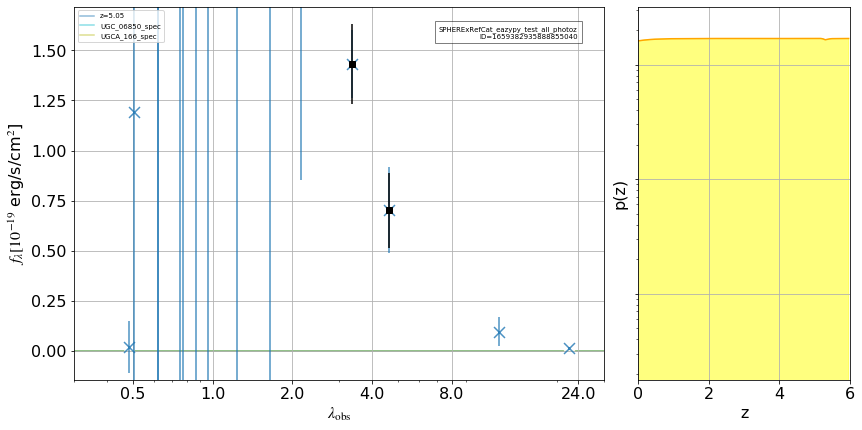

In [54]:
dummy = kasi_wrapper_fit_each_object_show(222, bcastez.value, verbose=True, get_best_fit=False, prior=True, beta_prior=False, fitter='nnls')

>>Fitting time: 0.020 s 
>>idx_fit: 4, zbest: 0.37705937, lnpmax: 2.3110955
>>Valid Bands:  [False False False  True  True  True  True False False False  True  True
  True  True  True]
>>NumValid Bands:  9


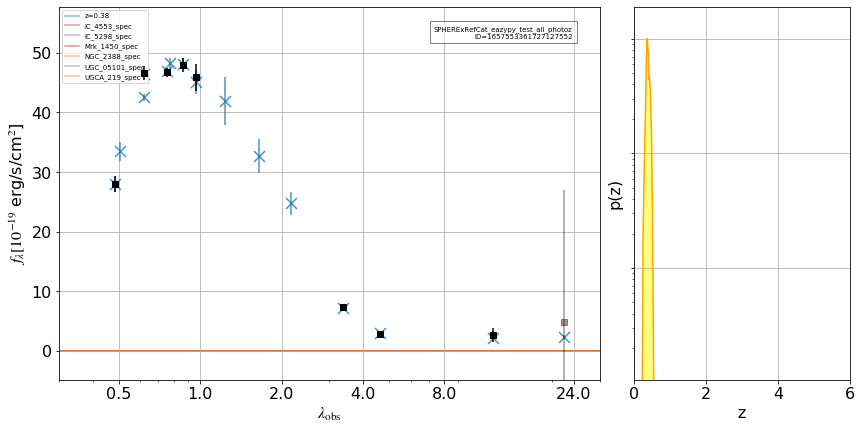

In [55]:
dummy = kasi_wrapper_fit_each_object_show(4, ez, verbose=True, get_best_fit=False, prior=True, beta_prior=False, fitter='nnls')

In [56]:
dummy['valid']

array([False, False, False,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True])

In [57]:
np.sum(dummy['valid'])

9

### New Wrapper for better visualization 

In [58]:
def kasi_wrapper_fit_each_object_show_new(idx_fit, ez, outfile=False, showplot=True, verbose=False, get_best_fit=True, \
                                          prior=False, beta_prior=False, \
                                          clip_wavelength=1100,fitter='nnls'):

    import numpy as np
    #import matplotlib.pyplot as plt
    import time
    #import multiprocessing as mp
    from collections import OrderedDict
    from eazy.photoz import template_lsq
    from eazy.photoz import utils
    from eazy.photoz import igm_module
    import astropy.units as u
    from scipy.integrate import cumtrapz
    
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    

    # plot settings
    #plt.rc('font', family='serif') 
    #plt.rc('font', serif='Times New Roman') 
    plt.rcParams.update({'font.size': 16})
    plt.rcParams['mathtext.fontset'] = 'stix'
    
    
    # nearest, interp
    TEMPLATE_REDSHIFT_TYPE = 'nearest'
    IGM_OBJECT = igm_module.Inoue14()

    

    fnu_corr = ez.fnu[idx_fit,:]*ez.ext_redden*ez.zp
    efnu_corr = ez.efnu[idx_fit,:]*ez.ext_redden*ez.zp
            
    efnu_corr[ez.fnu[idx_fit,:] < ez.param['NOT_OBS_THRESHOLD']] = ez.param['NOT_OBS_THRESHOLD'] - 9.
    
    #variables for show : SED 
    fnu_show = np.squeeze(ez.fnu[idx_fit,:])*ez.ext_redden*ez.zp
    efnu_show = np.squeeze(ez.efnu[idx_fit,:])*ez.ext_redden*ez.zp
    ok_band_show = (fnu_show/ez.zp > ez.param['NOT_OBS_THRESHOLD'])
    ok_band_show &= (efnu_show/ez.zp > 0)
    efnu_show[~ok_band_show] = ez.param['NOT_OBS_THRESHOLD'] - 9.
    zspec_show = ez.ZSPEC[idx_fit]
    
    log_prior_show = ez.full_logprior[idx_fit,:].flatten()
    
    #print("ix: ",idx_fit)
    #print("id: ",ez.OBJID[idx_fit])
    #print("fnu: ",fnu_show)
    #print("efnu: ",efnu_show)
    #print("ok_band: ",ok_band_show)
    #print("zspec: ",zspec_show)
    
    t0 = time.time()

    idummy, tempchi, tempcoeff, tempfmodel = kasi_fit_object(ez,iobj=idx_fit,z=0)
    #print("idummy ="+str(idummy))
    
    
    ''' We should avoid updating ez.DATAFIELDs to broad-cast `ez`. `ez` should only have setting parameters, not calculated results 
    ez.chi2_fit[idx_fit,:] = tempchi
    ez.fit_coeffs[idx_fit,:] = tempcoeff
    ez.fmodel[idx_fit,:] = tempfmodel
    kasi_compute_lnp(ez,prior=prior, beta_prior=beta_prior, in_place=True)
    '''

    # now, templnp is an 1d array and templnpmax is a scalar
    idummy2, templnp, templnpmax = kasi_compute_lnp_object(idx_fit,tempchi,ez, prior=prior, \
                                                           beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    # Fit the z-best using Parabola function
    zbest, lnpmaxbest = kasi_get_redshift_object(idx_fit, ez, templnp, templnpmax,get_best_fit=get_best_fit, prior=prior, \
                                          beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    t1 = time.time()
    
    
    pz = np.exp(templnp).flatten()
    normpz = pz/np.sum(pz)
    cumpz = np.cumsum(normpz)
    idxlower = np.argmax(cumpz >= 0.16)
    idxupper = np.argmax(cumpz >= 0.84)
    zlower = ez.zgrid[idxlower]
    zupper = ez.zgrid[idxupper]
    pzlower = pz[idxlower]
    pzupper = pz[idxupper]
    
    
    if verbose:
        print('>>Fitting time: {0:.3f} s '.format(t1-t0))
        '''
        print('>>idx_fit: '+str(idx_fit)+' lnpmax: '+str(ez.lnpmax[idx_fit]))
        '''
        print('>>idx_fit: '+str(idx_fit)+', zbest: '+str(zbest)+', lnpmax: '+str(lnpmaxbest))
    
    #variables for show : Coeffs at zbest
    ndraws = ez.NDRAWS
    tef_show = ez.TEF(zbest)
    A = np.squeeze(ez.tempfilt(zbest))
    chi2_show, coeffs_show, fmodel, draws = template_lsq(fnu_show, efnu_show, A, \
                                                         tef_show, ez.zp, ndraws, fitter='nnls')
    #print("ndraws: ",ndraws)
    #print("tef: ",tef_show)
    #print("chi2: ",chi2_show)
    #print("coeffs: ",coeffs_show)
    #print("fmodel: ",fmodel)
    #print("draws: ",draws)
    
    
    if draws is None:
        efmodel = 0
    else:
        efmodel = np.percentile(np.dot(draws, A), [16,84], axis=0)
        efmodel = np.squeeze(np.diff(efmodel, axis=0)/2.)
    
    #print("efmodel",efmodel)
    
    #variables for show : Full SED
    templ = ez.templates[0]
    tempflux = np.zeros((ez.NTEMP, templ.wave.shape[0]),dtype=ez.ARRAY_DTYPE)
    
    
    for i in range(ez.NTEMP):
        zargs = {'z':zbest, 'redshift_type':TEMPLATE_REDSHIFT_TYPE}
        fnu = ez.templates[i].flux_fnu(**zargs)*ez.tempfilt.scale[i]
    try:
        tempflux[i, :] = fnu
    except:
        tempflux[i, :] = np.interp(templ.wave,ez.templates[i].wave, fnu)
    
    
    templz = templ.wave*(1+zbest)
    
    if ez.tempfilt.add_igm:
        igmz = templ.wave*0.+1
        lyman = templ.wave < 1300
        igmz[lyman] = IGM_OBJECT.full_IGM(zbest, templz[lyman])
    else:
        igmz = 1.
    templf = np.dot(coeffs_show, tempflux)*igmz
    
    if draws is not None:
        templf_draws = np.dot(draws, tempflux)*igmz
    
    fnu_factor = 10**(-0.4*(ez.param['PRIOR_ABZP']+48.6))
    
    
    templz_power = -2
    flam_spec = utils.CLIGHT*1.e10/templz**2/1.e-19
    flam_sed = utils.CLIGHT*1.e10/ez.pivot**2/ez.ext_corr/1.e-19
    ylabel = (r'$f_\lambda [10^{-19}$ erg/s/cm$^2$]')
    flux_unit = 1.e-19*u.erg/u.s/u.cm**2/u.AA

    
    #print("tempflux: ",tempflux)
    #print("igmz: ",igmz)
    
    
    
    try:
        showdata = OrderedDict(ix=idx_fit,idobj=ez.OBJID[idx_fit], zbest=zbest, \
                               z_spec=zspec_show, pivot=ez.pivot, \
                               model=fmodel*fnu_factor*flam_sed, \
                               emodel=efmodel*fnu_factor*flam_sed, \
                               fobs=fnu_show*fnu_factor*flam_sed, \
                               efobs=efnu_show*fnu_factor*flam_sed, \
                               valid=ok_band_show, \
                               tef=tef_show, \
                               templz=templz, \
                               templf=templf*fnu_factor*flam_spec, \
                               flux_unit=flux_unit, \
                               wave_unit=u.AA, \
                               chi2=chi2_show, coeffs=coeffs_show)
    except:
        showdata = None
    
    
    print(">>Valid Bands: ",showdata['valid'])
    print(">>NumValid Bands: ",np.sum(showdata['valid']))
    
    ###### Make the plot
    axes=None
    figsize=[12,12]
    showpz=0.4
    template_color='#1f77b4'
    snr_thresh=2.
    with_tef=True
    show_upperlimits=True
    show_components=True
    show_redshift_draws=200
    draws_cmap=None
    if showplot:

        if axes is None:
            fig = plt.figure(figsize=figsize)
            if showpz:
                fig_axes = GridSpec(2,1,height_ratios=[1,showpz])
            else:    
                fig_axes = GridSpec(1,1,height_ratios=[1])
                
            ax = fig.add_subplot(fig_axes[0])
        else:
            fig = None
            fig_axes = None
            ax = axes[0]
                        
        ax.scatter(showdata['pivot']/1.e4, fmodel*fnu_factor*flam_sed, 
                   color='w', label=None, zorder=1, s=120, marker='o')
        
        ax.scatter(showdata['pivot']/1.e4, fmodel*fnu_factor*flam_sed, marker='x',
                  color=template_color, label=None, zorder=2, s=120, 
                  alpha=0.8)
        if draws is not None:
            ax.errorbar(showdata['pivot']/1.e4, fmodel*fnu_factor*flam_sed,
                        efmodel*fnu_factor*flam_sed, alpha=0.8,
                        color=template_color, zorder=2,
                        marker='None', linestyle='None', label=None)
            
        # Missing data
        missing = (fnu_show < ez.param['NOT_OBS_THRESHOLD']) 
        missing |= (efnu_show < 0)
        
        # Detection
        sn2_detection = (~missing) & (fnu_show/efnu_show > snr_thresh)
        
        # S/N < 2
        sn2_not = (~missing) & (fnu_show/efnu_show <= snr_thresh)
        
        # Uncertainty with TEF
        if with_tef:
            err_tef = np.sqrt(efnu_show**2+(tef_show*fnu_show)**2)            
        else:
            err_tef = efnu_show*1
            
        ax.errorbar(ez.pivot[sn2_detection]/1.e4, 
                    (fnu_show*fnu_factor*flam_sed)[sn2_detection], 
                    (err_tef*fnu_factor*flam_sed)[sn2_detection], 
                    color='k', marker='s', linestyle='None', label=None, 
                    zorder=10)
        
        # show upper limits
        if show_upperlimits:
            ax.errorbar(ez.pivot[sn2_not]/1.e4, 
                        (fnu_show*fnu_factor*flam_sed)[sn2_not], 
                        (efnu_show*fnu_factor*flam_sed)[sn2_not], color='k', 
                        marker='s', alpha=0.4, linestyle='None', label=None)

        pl = ax.plot(templz/1.e4, templf*fnu_factor*flam_spec, alpha=0.5, 
                     zorder=-1, color=template_color, 
                     label='z={0:.2f}'.format(zbest))
        
        # show components
        if show_components:
            colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
                      '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
            
            for i in range(ez.NTEMP):
                if coeffs_show[i] != 0:
                    pi = ax.plot(templz/1.e4, 
                        coeffs_show[i]*tempflux[i,:]*igmz*fnu_factor*flam_spec, 
                              alpha=0.5, zorder=-1, 
                              label=ez.templates[i].name.split('.dat')[0], 
                              color=colors[i % len(colors)])
                            
        if show_redshift_draws:
            
            if draws_cmap is None:
                draws_cmap = plt.cm.rainbow
                
            # Draw random values from p(z)
            pz = np.exp(templnp).flatten()
            pzcum = cumtrapz(pz, x=ez.zgrid)
            
            if show_redshift_draws == 1:
                nzdraw = 100
            else:
                nzdraw = show_redshift_draws*1
            
            rvs = np.random.rand(nzdraw)
            zdraws = np.interp(rvs, pzcum, ez.zgrid[1:])
            
            for zi in zdraws:
                Az = np.squeeze(ez.tempfilt(zi))
                chi2_zi, coeffs_zi, fmodelz, __ = template_lsq(fnu_show, efnu_show, 
                                                       Az, 
                                                       ez.TEF(zi), ez.zp, 
                                                       0, fitter='nnls')
                                                       
                c_i = np.interp(zi, ez.zgrid, np.arange(ez.NZ)/ez.NZ)
                
                templzi = templ.wave*(1+zi)
                if ez.tempfilt.add_igm:
                    igmz = templ.wave*0.+1
                    lyman = templ.wave < 1300
                    igmz[lyman] = IGM_OBJECT.full_IGM(zi, templzi[lyman])
                else:
                    igmz = 1.

                templfz = np.dot(coeffs_zi, tempflux)*igmz                
                templfz *=  flam_spec * (templz / templzi)**templz_power
                
                plz = ax.plot(templzi/1.e4, templfz*fnu_factor,
                             alpha=np.maximum(0.1, 1./nzdraw), 
                             zorder=-1, color=draws_cmap(c_i))
                
        if draws is not None:
            templf_width = np.percentile(templf_draws*fnu_factor*flam_spec, 
                                         [16,84], axis=0)
            ax.fill_between(templz/1.e4, templf_width[0,:], templf_width[1,:], 
                            color=pl[0].get_color(), alpha=0.1, label=None)
                
        # show x y labels 
        add_label=True
        FNTSIZE=20
        xlim=[0.3, 30]
        if axes is None:            
            ax.set_ylabel(ylabel)
            
            if sn2_detection.sum() > 0:
                ymax = (fmodel*fnu_factor*flam_sed)[sn2_detection].max()
            else:
                ymax = (fmodel*fnu_factor*flam_sed).max()
                        
            if np.isfinite(ymax):
                ax.set_ylim(-0.1*ymax, 1.2*ymax)

            ax.set_xlim(xlim)
            xt = np.array([0.1, 0.5, 1, 2, 4, 8, 24, 160, 500])*1.e4

            ax.semilogx()

            valid_ticks = (xt > xlim[0]*1.e4) & (xt < xlim[1]*1.e4)
            if valid_ticks.sum() > 0:
                xt = xt[valid_ticks]
                ax.set_xticks(xt/1.e4)
                ax.set_xticklabels(xt/1.e4)

            ax.set_xlabel(r'$\lambda_\mathrm{obs}$')
            ax.grid()
            
            if add_label:
                txt = '{0}\nID={1}'
                txt = txt.format(ez.param['MAIN_OUTPUT_FILE'], 
                                 showdata['idobj']) #, self.prior_mag_cat[ix])
                                 
                ax.text(0.95, 0.95, txt, ha='right', va='top', fontsize=FNTSIZE,
                        transform=ax.transAxes, 
                        bbox=dict(facecolor='w', alpha=0.5), zorder=10)
                
                ax.legend(fontsize=12, loc='center right')
        
                
        ## P(z)
        show_prior=False
        logpz=False
        zr=[0,6]
        zshow=zbest
        bool_pzlabels=False
        add_label=True
        if not showpz:
            return fig, showdata
            
        if axes is not None:
            if len(axes) == 1:
                return fig, showdata
            else:
                ax = axes[1]
        else:
            ax = fig.add_subplot(fig_axes[1])
        
        chi2 = np.squeeze(chi2_show)
        prior = np.exp(log_prior_show)
        #pz = np.exp(-(chi2-chi2.min())/2.)*prior
        #pz /= np.trapz(pz, self.zgrid)
        pz = np.exp(templnp).flatten()
        
        ax.plot(ez.zgrid, pz, color='orange', label=None)
        if show_prior:
            ax.plot(ez.zgrid, prior/prior.max()*pz.max(), color='g',
                label='prior')
        
        ax.fill_between(ez.zgrid, pz, pz*0, color='yellow', alpha=0.5, 
                        label=None)
        if zspec_show > 0:
            ax.vlines(zspec_show, 1.e-5, pz.max()*1.05, color='r',
                      label='zspec={0:.3f}'.format(zspec_show))
        
        if zshow is not None:
            ax.vlines(zlower, 1.e-5, pzlower, color=template_color, \
                      label='z_lower={0:.3f}'.format(zlower), linestyles='dotted')
            ax.vlines(zshow, 1.e-5, pz.max(), color=template_color, \
                      label='z_best={0:.3f}'.format(zshow))
            ax.vlines(zupper, 1.e-5, pzupper, color=template_color, \
                      label='z_upper={0:.3f}'.format(zupper), linestyles='dotted')
            
        if axes is None:
            ax.set_ylim(0,pz.max()*1.05)
            
            if logpz:
                ax.semilogy()
                ymax = np.minimum(ax.get_ylim()[1], 100)
                ax.set_ylim(1.e-3*ymax, 1.8*ymax)
                
            if zr is None:
                ax.set_xlim(0,self.zgrid[-1])
            else:
                ax.set_xlim(zr)
                
            ax.set_xlabel('z'); ax.set_ylabel('p(z)')
            ax.grid()
            if not bool_pzlabels:
                ax.set_yticklabels([])
            
            fig_axes.tight_layout(fig, pad=0.5)
            
            #if add_label & (zspec_show > 0):
            #    ax.legend(fontsize=7, loc='upper left')
            
            if add_label:
                ax.legend(fontsize=14, loc='upper right')
        # Save or not
        if outfile:
            fig.savefig(outfile)
            currentdir = %pwd
            print(">>"+outfile+" is saved on your current dirctory: "+currentdir)
    
    
    
    return showdata

>>Fitting time: 0.024 s 
>>idx_fit: 4, zbest: 0.37705937, lnpmax: 2.3110955
>>Valid Bands:  [False False False  True  True  True  True False False False  True  True
  True  True  True]
>>NumValid Bands:  9
>>sed-vis.png is saved on your current dirctory: /home/shong/work/sed-fit/pyspark-eazypy/notebook


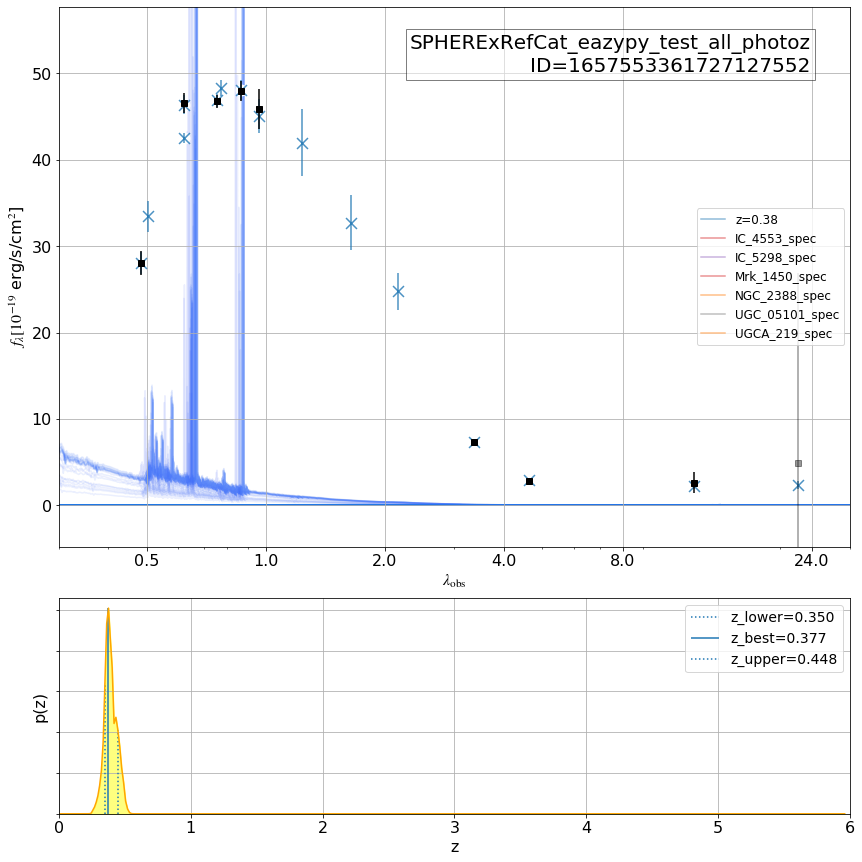

In [59]:
dummy = kasi_wrapper_fit_each_object_show_new(4, ez, outfile='sed-vis.png', verbose=True, get_best_fit=False, prior=True, beta_prior=False, fitter='nnls')

In [60]:
%%time
zbest, zlower, zupper = kasi_wrapper_fit_each_object_fast(4, bcastez.value,get_best_fit=False, prior=True, beta_prior=False, fitter='nnls')

CPU times: user 25.1 ms, sys: 0 ns, total: 25.1 ms
Wall time: 24.4 ms


In [61]:
%%time
zbest, zlower, zupper, nvalid = kasi_wrapper_fit_each_object(4, bcastez.value,get_best_fit=False, prior=True, beta_prior=False, fitter='nnls')

CPU times: user 20.8 ms, sys: 303 µs, total: 21.1 ms
Wall time: 20.8 ms


In [62]:
[zbest,zlower,zupper,nvalid]

[0.37705937, 0.34979177, 0.4476627, 9]

>>Fitting time: 0.021 s 
>>idx_fit: 123456, zbest: 0.3098994, lnpmax: 3.7130659
>>Valid Bands:  [False False False  True  True False False False False False  True  True
  True  True  True]
>>NumValid Bands:  7
>>sed-vis.png is saved on your current dirctory: /home/shong/work/sed-fit/pyspark-eazypy/notebook


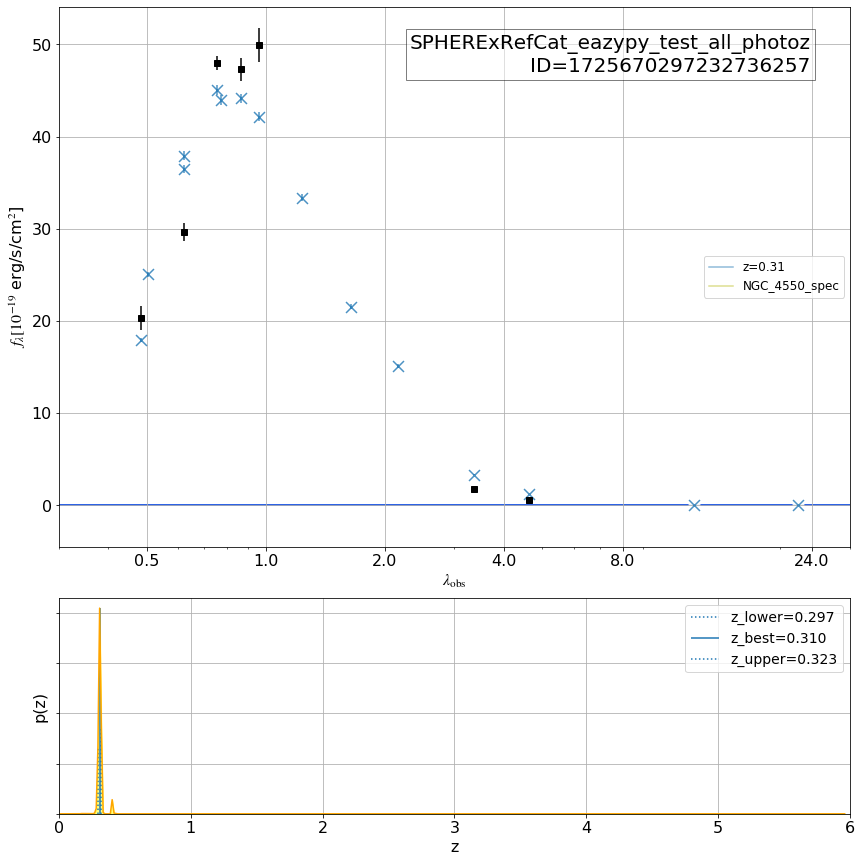

In [63]:
dummy = kasi_wrapper_fit_each_object_show_new(123456, bcastez.value, outfile='sed-vis.png', verbose=True, get_best_fit=False, prior=True, beta_prior=False, fitter='nnls')

In [64]:
zbest, zlower, zupper = kasi_wrapper_fit_each_object_fast(123456, bcastez.value,get_best_fit=False, prior=True, beta_prior=False, fitter='nnls')

In [65]:
[zbest,zlower,zupper]

[0.3098994, 0.29686567, 0.3230641]

>>Fitting time: 0.019 s 
>>idx_fit: 999, zbest: 0.4048778, lnpmax: 1.3110908
>>Valid Bands:  [False False False  True  True False False False False False  True  True
  True  True  True]
>>NumValid Bands:  7
>>sed-vis.png is saved on your current dirctory: /home/shong/work/sed-fit/pyspark-eazypy/notebook


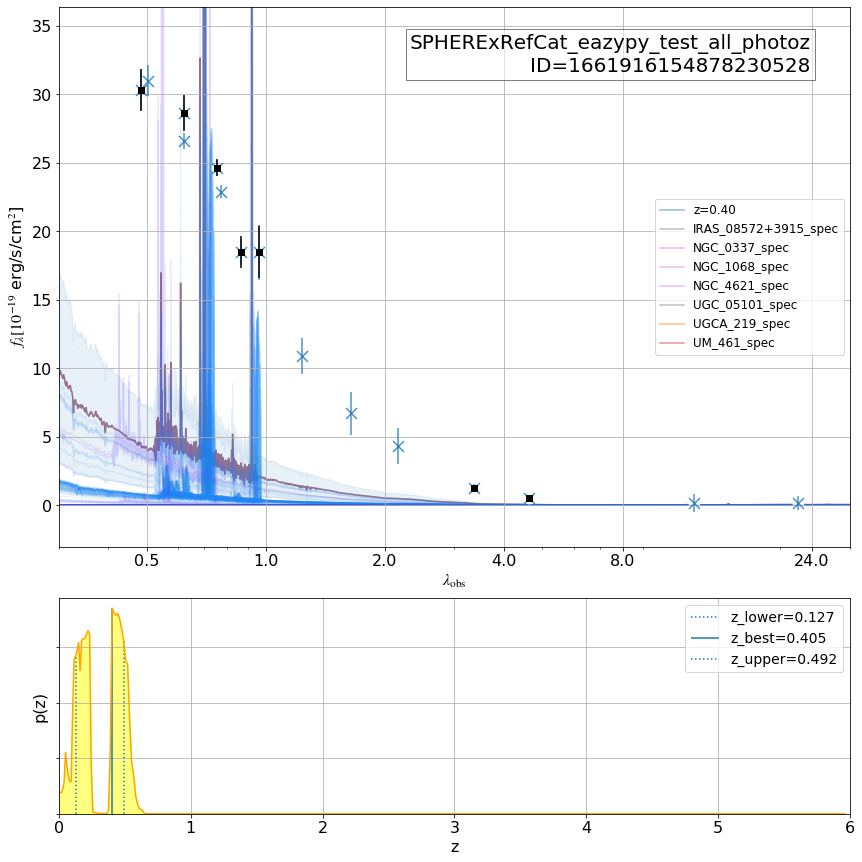

In [66]:
dummy = kasi_wrapper_fit_each_object_show_new(999, ez, outfile='sed-vis.png', verbose=True, get_best_fit=False, prior=True, beta_prior=False, fitter='nnls')

In [67]:
zbest, zlower, zupper = kasi_wrapper_fit_each_object_fast(999, bcastez.value,get_best_fit=False, \
                                                         prior=True, beta_prior=False, fitter='nnls')

In [68]:
[zbest,zlower,zupper]

[0.4048778, 0.12744085, 0.4917506]

>>Fitting time: 0.023 s 
>>idx_fit: 736, zbest: 0.61599416, lnpmax: 2.280231
>>Valid Bands:  [False False False  True  True False False False False False  True  True
  True  True  True]
>>NumValid Bands:  7
>>sed-vis.png is saved on your current dirctory: /home/shong/work/sed-fit/pyspark-eazypy/notebook


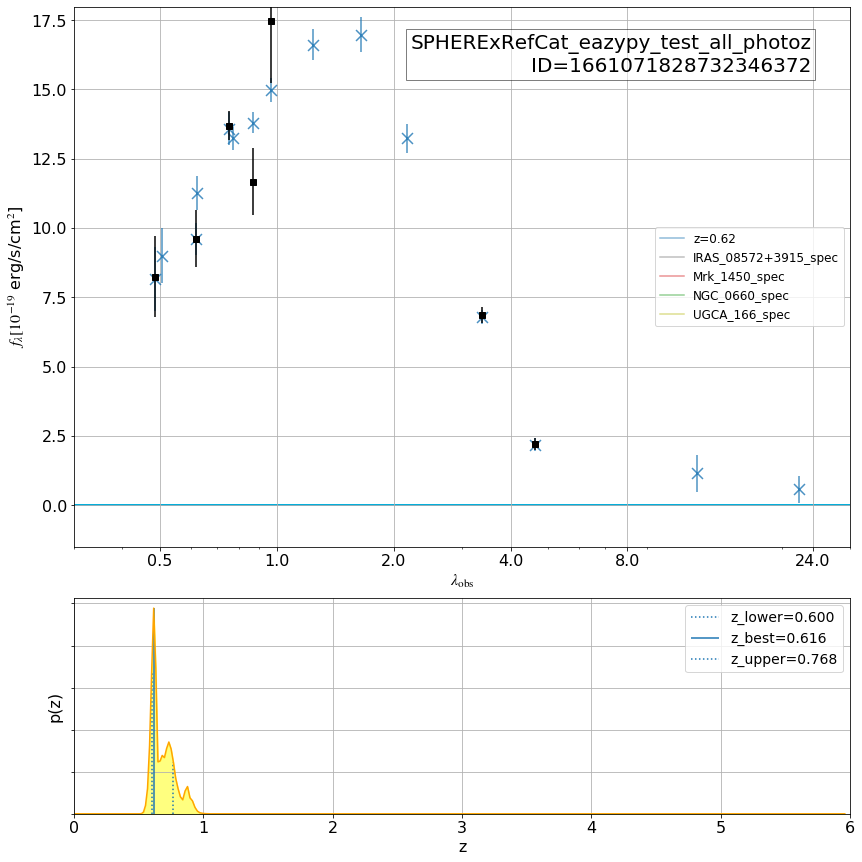

In [69]:
dummy = kasi_wrapper_fit_each_object_show_new(736, ez, outfile='sed-vis.png', verbose=True, get_best_fit=False, prior=True, beta_prior=False, fitter='nnls')

In [70]:
zbest, zlower, zupper = kasi_wrapper_fit_each_object_fast(736, bcastez.value,get_best_fit=False, \
                                                         prior=True, beta_prior=False, fitter='nnls')

In [71]:
[zbest, zlower, zupper]

[0.61599416, 0.5999147, 0.76817924]

In [72]:
#print(showdata)

>>Fitting time: 0.025 s 
>>idx_fit: 5, zbest: 0.6546126487199366, lnpmax: 1.5883853632708451
>>Valid Bands:  [False False False  True  True  True  True False False False  True  True
  True  True  True]
>>NumValid Bands:  9


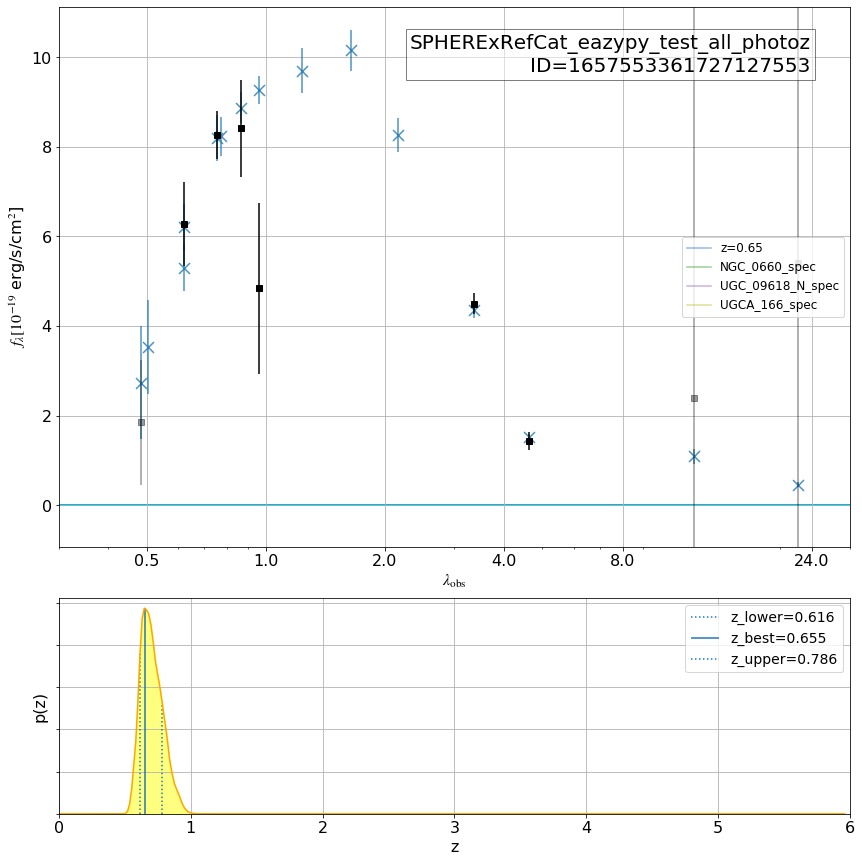

In [73]:
dummy = kasi_wrapper_fit_each_object_show_new(5, ez, verbose=True, get_best_fit=True, prior=False, beta_prior=False, fitter='nnls')

In [74]:
zbest, zlower, zupper = kasi_wrapper_fit_each_object_fast(5, bcastez.value,get_best_fit=False, \
                                                         prior=True, beta_prior=False, fitter='nnls')

In [75]:
[zbest, zlower, zupper]

[0.6486394, 0.61599416, 0.7859497]

>>Fitting time: 0.026 s 
>>idx_fit: 10000, zbest: 0.43325824, lnpmax: 1.0432746
>>Valid Bands:  [False False False  True  True  True  True False False False  True  True
  True  True  True]
>>NumValid Bands:  9


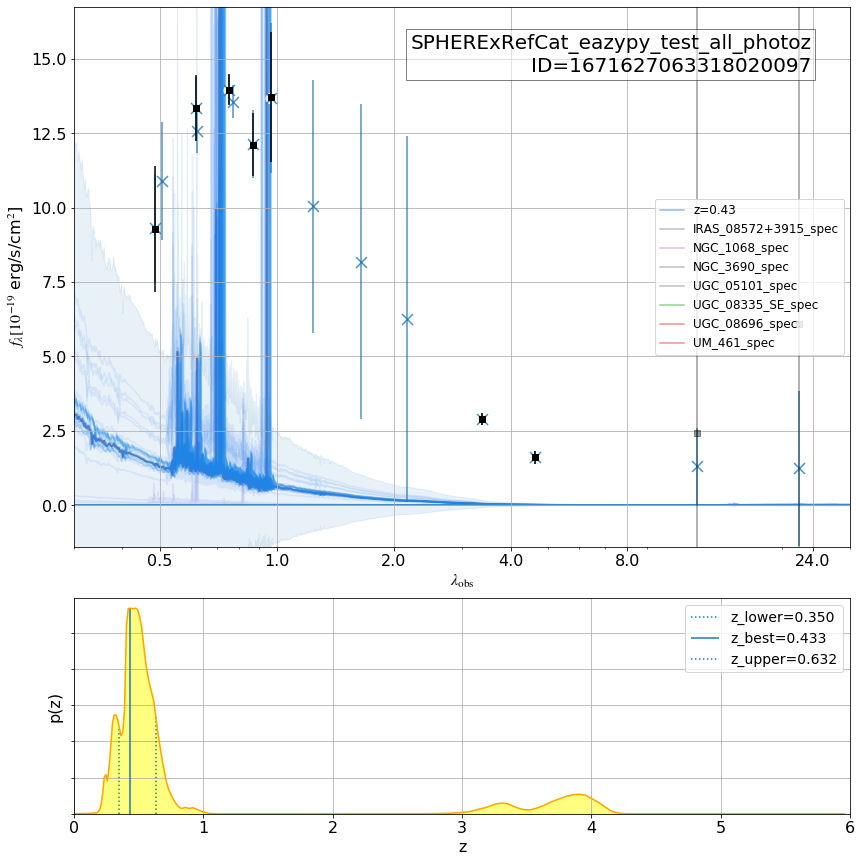

In [76]:
dummy = kasi_wrapper_fit_each_object_show_new(10000, ez, verbose=True, get_best_fit=False, prior=False, beta_prior=False, fitter='nnls')

### Finally, testing the first and last objects in the input catalog

>>Fitting time: 0.017 s 
>>idx_fit: 0, zbest: 5.049347, lnpmax: -1.775353
>>Valid Bands:  [False False False  True  True False False False False False False False
 False False False]
>>NumValid Bands:  2


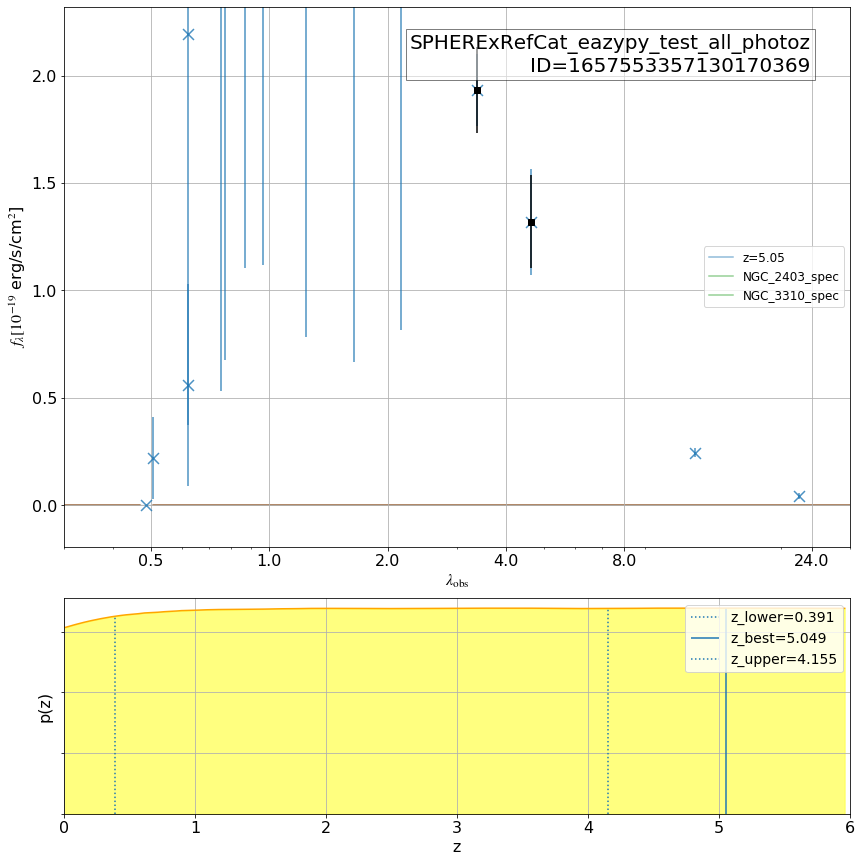

In [77]:
dummy = kasi_wrapper_fit_each_object_show_new(0, ez, verbose=True, get_best_fit=False, prior=False, beta_prior=False, fitter='nnls')

>>Fitting time: 0.023 s 
>>idx_fit: 124116, zbest: 0.01, lnpmax: 5.283363
>>Valid Bands:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
>>NumValid Bands:  15


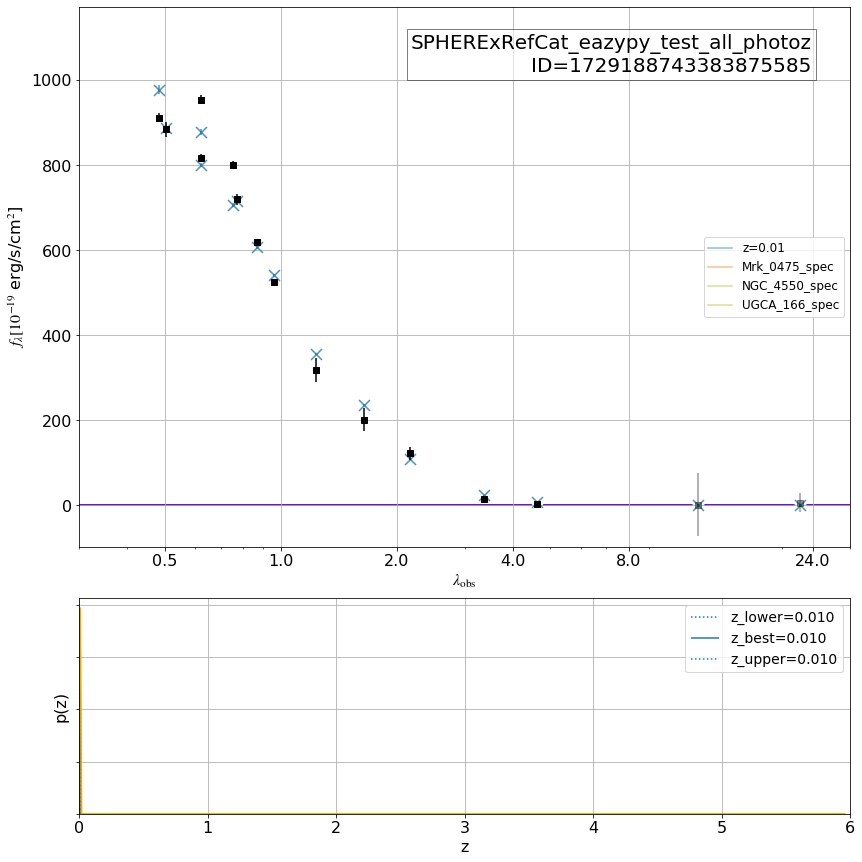

In [78]:
dummy = kasi_wrapper_fit_each_object_show_new(124116, ez, verbose=True, get_best_fit=False, prior=False, beta_prior=False, fitter='nnls')

### Rough estimation of running time

In [79]:
0.025 * len(photdf.index) / 3600.0

0.8619236111111112

> For each sed-fit, 0.025sec. <br> For the `len(photdf.index)`, roughly 112k, it will take 51 minutes. 

In [80]:
0.025 * 1000000000.0 / 3600.0 /24.0 #in days, for 1 billion objects

289.35185185185185

# PySpark Running Time on Yarn MultiNodes 

> Running Time Testing of SEDFIT on 4k objects

In [81]:
numcat = bcastez.value.NOBJ
print(numcat)

124117


In [82]:
numcat = 10000 # trying only 10k"

### Explore datatypes and convert `numpy array` into a PySpark dataframe `runsparkdf`

In [83]:
irun = bcastez.value.idx[:numcat]
iobj = bcastez.value.OBJID[:numcat].value

In [84]:
irun

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [85]:
iobj

array([1657553357130170369, 1657553357130170370, 1657553357398605824, ...,
       1671627054811971585, 1671627059023052800, 1671627063016030208])

In [86]:
print(irun.dtype)

int64


In [87]:
print(iobj.dtype)

int64


#### zip the two numpy arrays into a zipped tuple 

In [88]:
zipdata = list(zip(irun.tolist(), iobj.tolist()))

In [89]:
isinstance(zipdata[0],tuple)

True

In [90]:
isinstance(zipdata[0],np.ndarray)

False

In [91]:
len(zipdata)

10000

In [92]:
zipdata[0]

(0, 1657553357130170369)

In [93]:
zipdata[0][1]

1657553357130170369

#### spark dataframe for running SED on each object

In [94]:
run_schema = T.StructType([ \
                           T.StructField("idx_run", T.LongType(), nullable=False), \
                           T.StructField("id_obj", T.LongType(), nullable=False) \
                          ])

In [95]:
runsparkdf = spark.createDataFrame(list(zip(irun.tolist(), iobj.tolist())), schema=run_schema)

In [96]:
runsparkdf.printSchema()

root
 |-- idx_run: long (nullable = false)
 |-- id_obj: long (nullable = false)



In [97]:
runsparkdf.show(5,truncate=True)

+-------+-------------------+
|idx_run|             id_obj|
+-------+-------------------+
|      0|1657553357130170369|
|      1|1657553357130170370|
|      2|1657553357398605824|
|      3|1657553361425137666|
|      4|1657553361727127552|
+-------+-------------------+
only showing top 5 rows



In [98]:
runsparkdf.orderBy("idx_run", ascending=False).limit(5).show()

+-------+-------------------+
|idx_run|             id_obj|
+-------+-------------------+
|   9999|1671627063016030208|
|   9998|1671627059023052800|
|   9997|1671627054811971585|
|   9996|1671627054728085504|
|   9995|1671627050399563777|
+-------+-------------------+



### Define UDF and Run PySpark!!

####  `partial` the fitting function

```
def kasi_wrapper_fit_each_object_fast(idx_fit, ez, get_best_fit=True, prior=False, beta_prior=False, \
                                 clip_wavelength=1100,fitter='nnls'):
```

In [99]:
def pyspark_sedfit_fast(idx_fit, ezinput, get_best_fit=True, prior=False, beta_prior=False, \
                                 clip_wavelength=1100,fitter='nnls'):

    import numpy as np
    #import matplotlib.pyplot as plt
    #import time
    #import multiprocessing as mp

    ez = ezinput.value

    fnu_corr = ez.fnu[idx_fit,:]*ez.ext_redden*ez.zp
    efnu_corr = ez.efnu[idx_fit,:]*ez.ext_redden*ez.zp
    
            
    efnu_corr[ez.fnu[idx_fit,:] < ez.param['NOT_OBS_THRESHOLD']] = ez.param['NOT_OBS_THRESHOLD'] - 9.
    #t0 = time.time()

    idummy, tempchi, tempcoeff, tempfmodel = kasi_fit_object(ez,iobj=idx_fit,z=0)
    #print("idummy ="+str(idummy))
    
    
    ''' We should avoid updating ez.DATAFIELDs to broad-cast `ez`. `ez` should only have setting parameters, not calculated results 
    ez.chi2_fit[idx_fit,:] = tempchi
    ez.fit_coeffs[idx_fit,:] = tempcoeff
    ez.fmodel[idx_fit,:] = tempfmodel
    kasi_compute_lnp(ez,prior=prior, beta_prior=beta_prior, in_place=True)
    '''

    # now, templnp is an 1d array and templnpmax is a scalar
    idummy2, templnp, templnpmax = kasi_compute_lnp_object(idx_fit,tempchi,ez, prior=prior, \
                                                           beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    # Fit the z-best using Parabola function
    zbest, lnpmaxbest = kasi_get_redshift_object(idx_fit, ez, templnp, templnpmax,get_best_fit=get_best_fit, prior=prior, \
                                          beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    pz = np.exp(templnp).flatten()
    normpz = pz/np.sum(pz)
    cumpz = np.cumsum(normpz)
    idxlower = np.argmax(cumpz >= 0.16)
    idxupper = np.argmax(cumpz >= 0.84)
    
    #t1 = time.time()
    
    return [zbest,ez.zgrid[idxlower],ez.zgrid[idxupper]]


In [100]:
kasi_wrapper_fit_each_object_fast(5, bcastez.value,get_best_fit=False, \
                                                         prior=True, beta_prior=False, fitter='nnls')

[0.6486394, 0.61599416, 0.7859497]

In [101]:
kasi_wrapper_fit_each_object_fast(5, bcastez.value)

[0.6546126487199366, 0.61599416, 0.7859497]

In [102]:
pyspark_sedfit_fast(5, bcastez,get_best_fit=False, \
                    prior=True, beta_prior=False, fitter='nnls')

[0.6486394, 0.61599416, 0.7859497]

In [103]:
pyspark_sedfit_fast(5, bcastez)

[0.6546126487199366, 0.61599416, 0.7859497]

In [104]:
from functools import partial

In [105]:
partial_func = partial(pyspark_sedfit_fast, ezinput = bcastez, \
                            get_best_fit=False, prior=True, beta_prior=False, fitter='nnls')

In [106]:
partial_func(5)

[0.6486394, 0.61599416, 0.7859497]

In [107]:
partial_func(99)

[5.3595037, 5.3595037, 5.3595037]

#### Define a UDF

In [108]:
fitudf = F.udf(partial_func, T.ArrayType(T.DoubleType()))

#### Final Result DataFrame

In [109]:
%%time
resultdf = runsparkdf.withColumn('zphot',fitudf('idx_run')).cache()

CPU times: user 4.63 ms, sys: 1.07 ms, total: 5.7 ms
Wall time: 45.6 ms


In [110]:
%%time
resultdf.collect()

Py4JJavaError: An error occurred while calling o162.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 21 in stage 3.0 failed 4 times, most recent failure: Lost task 21.3 in stage 3.0 (TID 205) (spark15 executor 84): net.razorvine.pickle.PickleException: expected zero arguments for construction of ClassDict (for numpy.dtype). This happens when an unsupported/unregistered class is being unpickled that requires construction arguments. Fix it by registering a custom IObjectConstructor for this class.
	at net.razorvine.pickle.objects.ClassDictConstructor.construct(ClassDictConstructor.java:23)
	at net.razorvine.pickle.Unpickler.load_reduce(Unpickler.java:759)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:199)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:109)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:122)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.$anonfun$evaluate$6(BatchEvalPythonExec.scala:94)
	at scala.collection.Iterator$$anon$10.nextCur(Iterator.scala:587)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:601)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:576)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:576)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:118)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:576)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1518)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1445)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1509)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1332)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:327)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.immutable.List.foreach(List.scala:333)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:424)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3688)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3685)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: net.razorvine.pickle.PickleException: expected zero arguments for construction of ClassDict (for numpy.dtype). This happens when an unsupported/unregistered class is being unpickled that requires construction arguments. Fix it by registering a custom IObjectConstructor for this class.
	at net.razorvine.pickle.objects.ClassDictConstructor.construct(ClassDictConstructor.java:23)
	at net.razorvine.pickle.Unpickler.load_reduce(Unpickler.java:759)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:199)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:109)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:122)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.$anonfun$evaluate$6(BatchEvalPythonExec.scala:94)
	at scala.collection.Iterator$$anon$10.nextCur(Iterator.scala:587)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:601)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:576)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:576)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:118)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:576)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1518)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1445)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1509)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1332)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:327)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)


# FINAL Verdict: (rage version)

> The fundamental basic theor for cloud computing is : 

- "Storage" and "Computation" must be separate from each other. 

> The same concept also should be applied when making a `class`, which should be broadcastable to other nodes, 

- "Data" and "Computation Function" must be separate from each other. 

But, `astropy` has all mixed structures, and tragically many `astro-related` packages follow such cata-`astropy`-ic path. Alas.. woo to `astropy` and woo to LSST pipelines! 


# Sequential Running Time with a single thread

In [111]:
listzphotbest = []
listzphot16 = []
listzphot84 = []

In [112]:
from tqdm import tqdm

In [113]:
%%time
for idx in tqdm(range(numcat), position=0, leave=True):
    zbest, zlower, zupper = \
    kasi_wrapper_fit_each_object_fast(idx, bcastez.value,get_best_fit=False, \
                                 prior=True, beta_prior=False, fitter='nnls')
    
    listzphotbest.append(zbest)
    listzphot16.append(zlower)
    listzphot84.append(zupper)

100%|██████████| 10000/10000 [02:58<00:00, 56.10it/s]

CPU times: user 2min 58s, sys: 116 ms, total: 2min 58s
Wall time: 2min 58s
